In [2]:
#
import numpy as np
import os, sys

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgstargets/py')

from io_ import get_sweep_whole, getBGSbits, flux_to_mag, cut
from io_ import get_random, get_isdesi, get_dict, bgsmask, get_reg, get_svfields, get_svfields_fg, get_svfields_ij, gaiaAEN
from cuts import getGeoCuts, bgsbut
from QA import getStats, flow, mollweide, mycmap, plot_sysdens, overdensity, hexbin
from postages_images import postages_circle

import healpy as hp
import astropy.io.fits as fits
import fitsio
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib

from astropy.coordinates import SkyCoord
import astropy.units as unitstick
from astropy.table import Table, Column

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [3]:
#
dr = 'dr8'
survey = 'south' #is either south (DECaLS+DES) or north (BASS/MzLS)
version = '0.1.0'
filesdir = '/global/cscratch1/sd/qmxp55/bgstargets_output/'
Nranfiles = 3
#reg = 'svfields_ij'
#reg = 'svfields'
reg = 'south'
dec_resol_ns = 32.375
if (dr[:3] == 'dr9'): Nranfiles = 20 # because the randoms for dr9d have a density of 100000 = 5000*20

pathdir = os.path.abspath(os.getcwd())+'/%s-%s_%s_%s_draft_plots' %(dr, survey, reg, version)
ispathdir = os.path.isdir(pathdir)
if not ispathdir: os.mkdir(pathdir)
    
if reg[:8] == 'svfields': desifootprint = False
else: desifootprint = True

# for healpy
dr8pix     = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
hdr          = fits.getheader(dr8pix,1)
nside,nest   = hdr['hpxnside'],hdr['hpxnest']
npix         = hp.nside2npix(nside)
pixarea      = hp.nside2pixarea(nside,degrees=True)

In [4]:
#load catalogues
if dr[:3] == 'dr9': N = 1
else: N = Nranfiles
    
#%time cat = np.load(filesdir+dr+'/'+version+'/'+'bgstargets-'+survey+'.npy', mmap_mode='r+')
%time cat = np.load(filesdir+dr+'/'+version+'/'+'bgstargets-'+survey+'.npy')
%time cat_ex = np.load(filesdir+dr+'/'+version+'/'+'extra-'+survey+'_n256.npy')


CPU times: user 2.04 ms, sys: 1min 16s, total: 1min 16s
Wall time: 1min 17s
CPU times: user 0 ns, sys: 1min 8s, total: 1min 8s
Wall time: 1min 9s


In [5]:
#
%time catinreg = (cat_ex[reg]) & (cat_ex['desi'])
%time cat = cat[catinreg]
%time cat_ex = cat_ex[catinreg]

CPU times: user 653 ms, sys: 76 ms, total: 729 ms
Wall time: 729 ms
CPU times: user 11.3 s, sys: 1min 18s, total: 1min 29s
Wall time: 1min 7s
CPU times: user 2.76 s, sys: 2.89 s, total: 5.65 s
Wall time: 4.21 s


In [6]:
#
%time ran = np.load(filesdir+dr+'/'+dr+'_random_N'+str(N)+'.npy')
%time ran_ex = np.load(filesdir+dr+'/'+'extra_random_N'+str(N)+'_n256.npy', mmap_mode='r+')

CPU times: user 992 µs, sys: 8.17 s, total: 8.17 s
Wall time: 8.4 s
CPU times: user 0 ns, sys: 8 ms, total: 8 ms
Wall time: 33 ms


In [7]:
#
%time raninreg = (ran_ex[reg]) & (ran_ex['desi'])
%time ran = ran[raninreg]
%time ran_ex = ran_ex[raninreg]

CPU times: user 3.72 s, sys: 1min, total: 1min 4s
Wall time: 1min 5s
CPU times: user 3.49 s, sys: 19.6 s, total: 23.1 s
Wall time: 23.2 s
CPU times: user 4.8 s, sys: 15.1 s, total: 19.9 s
Wall time: 20 s


In [8]:
#
%time catinreg = (cat_ex[reg]) & (cat_ex['desi'])
%time raninreg = (ran_ex[reg]) & (ran_ex['desi'])

CPU times: user 960 ms, sys: 5.32 s, total: 6.28 s
Wall time: 6.32 s
CPU times: user 1.63 s, sys: 3.85 s, total: 5.49 s
Wall time: 5.51 s


``` python
hppix_ran = ran_ex['hppix']
ranindesi = ran_ex['desi']

hppix_cat = cat_ex['hppix']
catindesi = cat_ex['desi']

if (reg == 'svfields_ij'):
    
    raninreg = get_svfields_ij(ran['RA'], ran['DEC'], survey=survey)
    catinreg = get_svfields_ij(cat['RA'], cat['DEC'], survey=survey)
    
else:

    #if svfields don't use desifootprint
    #tunning in south as dr9f/dr9g does not entirely cover southern ages region
    if (reg == 'svfields_fg') & (survey == 'south'): tun, tun_ran = (cat['DEC'] < 30), (ran['DEC'] < 30)
    else: tun, tun_ran = np.ones_like(cat['RA'], dtype=bool), np.ones_like(ran['RA'], dtype=bool)
    #tunning in north as dr9f/dr9g does not entirely cover highstardens_n region
    if (reg == 'svfields_fg') & (survey == 'north'): tun2, tun2_ran = (cat['RA'] < 280), (ran['RA'] < 280)
    else: tun2, tun2_ran = np.ones_like(cat['RA'], dtype=bool), np.ones_like(ran['RA'], dtype=bool)

    if not desifootprint: raninreg = (ran_ex[reg]) & (ran_ex[survey]) & (tun_ran) & (tun2_ran)
    else: raninreg = (ran_ex[reg]) & (ran_ex['desi']) & (ran_ex[survey]) & (tun_ran) & (tun2_ran)

    #if svfields don't use desifootprint
    if not desifootprint: catinreg = (cat_ex[reg]) & (cat_ex[survey]) & (tun) & (tun2)
    else: catinreg = (cat_ex[reg]) & (cat_ex['desi']) & (cat_ex[survey]) & (tun) & (tun2)
```

## Filter catalogue and randoms by region

``` python
#RANDOMS
ran = ran[raninreg]
ran_ex = ran_ex[raninreg]
ranindesi = ranindesi[raninreg]
hppix_ran = hppix_ran[raninreg]
raninreg = raninreg[raninreg]

#CATALOGUE
cat = cat[catinreg]
cat_ex = cat_ex[catinreg]
catindesi = catindesi[catinreg]
hppix_cat = hppix_cat[catinreg]
catinreg = catinreg[catinreg]
```

In [9]:
#bgsmask = bgsmask()
rancuts = getGeoCuts(ran, randoms=True)

## getting area of reg with healpix pixels (for flow charts...)

NOTE: if using SVFIELDS footprint, use `desifootprint=False` otherwise the area will be less than the current SVFIELDS due desi footprint chops out part of it.

In [10]:
#Notes: This hpdict is used to get the area only using the randoms. 
#This use the randoms within the DESI footprint and without any masking (maskrand=None) as we want the area without wholes.
hpdict0 = get_dict(cat=None, pixmapfile=dr8pix, hppix_ran=ran_ex['hppix'], hppix_cat=None, 
                      maskrand=None, maskcat=None, Nranfiles=Nranfiles, ranindesi=ran_ex['desi'], catindesi=None, 
                            desifootprint=desifootprint, namesels=None, target_outputs=False, log=False)

## Healpy pixels catalogue with BGS target density (for dens. sky maps and systematics plots...)

In [11]:
#from astropy.coordinates import SkyCoord
#import astropy.units as units

#c = SkyCoord(cat['RA']*units.degree,cat['DEC']*units.degree, frame='icrs')
#galb = c.galactic.b.value # galb coordinate

In [12]:
#dic with default BGS selection and in DESI footprint
#Appy or not apply LG mask in randoms (rancuts['LG'])?
hpdict = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=ran_ex['hppix'], hppix_cat=cat_ex['hppix'], 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ran_ex['desi'], catindesi=None, 
                                desifootprint=desifootprint, namesels={'bgs_any':20, 'bright':21, 'faint':22}, 
                                  galb=cat_ex['b'], log=False, survey='bgs')

## BGS outline

In [13]:
#
bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)
bgs_b = ((cat['BGSBITS'] & 2**(21)) != 0)
bgs_f = ((cat['BGSBITS'] & 2**(22)) != 0)

print('mean density of BGS: \t %.2f' %(hpdict['meandens_bgs_any_'+survey]))
#print('total density of BGS: \t %.2f' %(hpdict['dens_bgs_any_'+survey]))
print('Area within BGS: \t %.2f' %(hpdict['bgsarea_'+survey]))

print('No BGS galaxies in Bright and Faint: \t %i \t %i \t %i' %(
    np.sum(bgs_b),
    np.sum(bgs_f),
    np.sum(bgs_any)
))


print('Overall density of BGS: \t %d \t %d \t %d' %(
    np.round(hpdict['dens_bright_'+survey], 0),
    np.round(hpdict['dens_faint_'+survey], 0),
    np.round(hpdict['dens_bgs_any_'+survey], 0)
))

print('morph \t BRIGHT \t FAINT \t OVERALL')
print('------------------------------------')
for morph in list(set(cat['TYPE'][:10000])):
    
    keep = cat['TYPE'] == morph
    print('%s \t %d \t %d \t %d' %(
        morph, 
        np.round(np.sum((keep) & (bgs_b))/hpdict['bgsarea_'+survey], 0),
        np.round(np.sum((keep) & (bgs_f))/hpdict['bgsarea_'+survey], 0),
        np.round(np.sum((keep) & (bgs_any))/hpdict['bgsarea_'+survey], 0),
        ))


mean density of BGS: 	 1424.00
Area within BGS: 	 9408.56
No BGS galaxies in Bright and Faint: 	 7944975 	 5433087 	 13378062
Overall density of BGS: 	 844 	 577 	 1422
morph 	 BRIGHT 	 FAINT 	 OVERALL
------------------------------------
EXP  	 284 	 229 	 513
PSF  	 3 	 2 	 5
COMP 	 27 	 3 	 31
REX  	 104 	 141 	 246
DEV  	 426 	 202 	 628


In [13]:
if dr[:3] == 'dr9': 
    morphos = ['REX', 'EXP', 'DEV', 'SER']
    PSF = ['PSF']
else: 
    morphos = ['REX ', 'EXP ', 'DEV ', 'COMP']
    PSF = ['PSF ']

In [14]:
set(cat['TYPE'][:10000])

{'COMP', 'DEV ', 'EXP ', 'PSF ', 'REX '}

## number counts

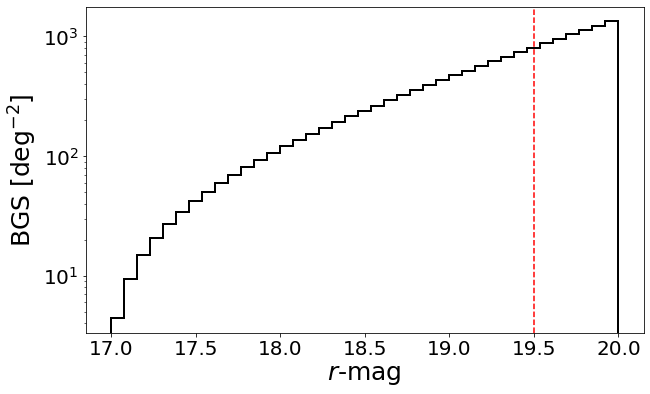

In [17]:
#
area = hpdict0['bgsarea_'+reg]
fig = plt.figure(figsize=(10,6))

rbins = np.linspace(17, 20, 40)
plt.hist(cat['RMAG'][bgs_any], bins=rbins, histtype='step', lw=2, color='k', cumulative=True, weights=np.full(np.sum(bgs_any), 1/area))

plt.axvline(19.5, ls='--', c='r')
#plt.axhline(800, ls='--', c='r')

plt.xlabel(r'$r$-mag', size=25)
plt.ylabel(r'BGS [deg$^{-2}$]', size=25)
#plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.yscale('log')

plt.show()

file = '%s/number_counts' %(pathdir)
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0, dpi=300)


#### BGS dens. sky maps

In [34]:
from QA import mollweide, mycmap, plot_sysdens
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib

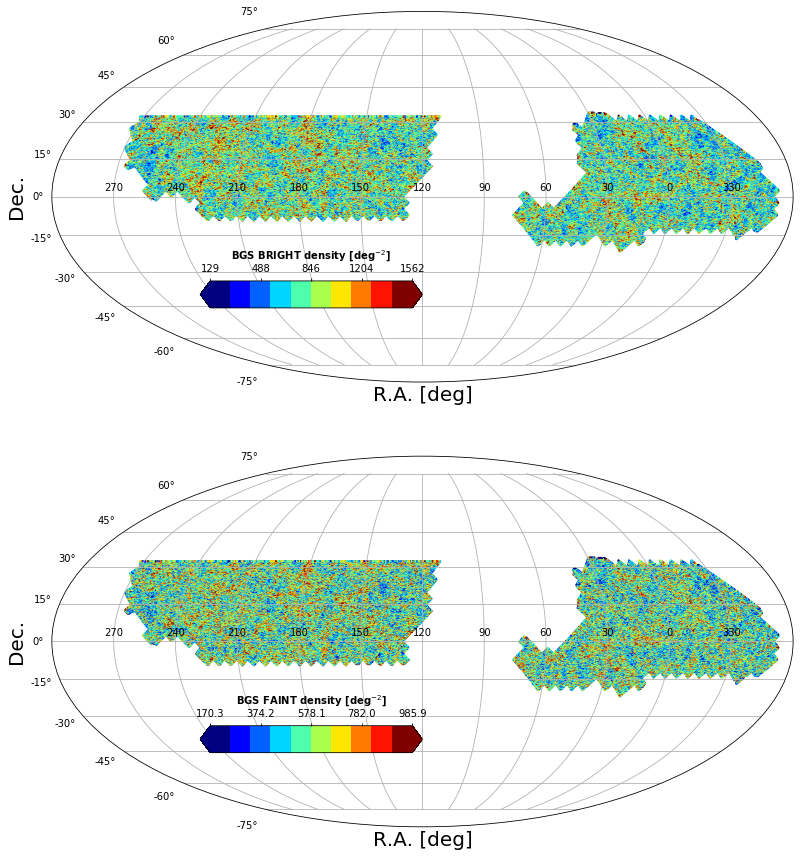

In [35]:
#
if reg[:8] == 'svfields': reg_ = reg+'_'+survey[0]
else: reg_ = reg
    
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(2,1)
    
org          = 120  # centre ra for mollweide plots
projection   = 'mollweide'
cm = mycmap(matplotlib.cm.jet, 10,0,1)
cmr= mycmap(matplotlib.cm.jet_r,10,0,1)

mollweide(hpdict=hpdict, namesel='bright', reg=reg_, projection=projection, n=0, org=org, cm=cm, fig=fig, gs=gs, cval=None, desifootprint=False, cname='BGS BRIGHT')
mollweide(hpdict=hpdict, namesel='faint', reg=reg_, projection=projection, n=1, org=org, cm=cm, fig=fig, gs=gs, cval=None, desifootprint=False, cname='BGS FAINT')
#mollweide(hpdict=hpdict, C=None ,namesel='any', reg='all', projection=projection, n=1, org=org, cm=cm, 
#          fig=fig, ws=ws, perc=(0.3,99.8), title='After linear weights', cval=(84, 2750))

file = '%s/skydens_%s_%s' %(pathdir, dr, reg)
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0, dpi=300)


## Flow charts: Nominal & Galaxy View

In [19]:
#
for key in ['BS', 'LG', 'MS']:
    
    bgslist = ['BS', 'LG', 'GC', 'nobs', 'SG', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF']
    if key in bgslist: bgslist.remove(key)

    t = getStats(cat=cat, hpdict=hpdict0, bgsmask=bgsmask(), rancuts=rancuts, CurrentMask=[key], 
             PrevMask=None, reg=reg, regcat=catinreg, regran=raninreg)
    
    t2 = getStats(cat=cat, hpdict=hpdict0, bgsmask=bgsmask(), rancuts=rancuts, CurrentMask=[key], 
             PrevMask=bgslist, reg=reg, regcat=catinreg, regran=raninreg)
    
    print('%s: \t %.1f %% \t %.1f /sq.deg' %(key, t[0][1], t2[0][2]+t[0][3]))
    #print('------------------------------ ')
    

Previous Cuts: (None)
Current Cuts: (BS)
Previous Cuts: (LG|GC|nobs|SG|FMC2|CC|QC_FM|QC_FI|QC_FF)
Current Cuts: (BS)
BS: 	 2.8 % 	 41.5 /sq.deg
Previous Cuts: (None)
Current Cuts: (LG)
Previous Cuts: (BS|GC|nobs|SG|FMC2|CC|QC_FM|QC_FI|QC_FF)
Current Cuts: (LG)
LG: 	 0.1 % 	 4.8 /sq.deg
Previous Cuts: (None)
Current Cuts: (MS)
Previous Cuts: (BS|LG|GC|nobs|SG|FMC2|CC|QC_FM|QC_FI|QC_FF)
Current Cuts: (MS)
MS: 	 4.6 % 	 75.5 /sq.deg


In [20]:
#use below code to get target densities of keep and rejected at a particular stage in flowchart...
#use hpdict0 if density computed over the total area (before applyin spatial cuts in randoms)
#use hpdict if density computed over the reduced area (after applying spatial cuts in randoms)
if False:
    t = getStats(cat=cat, hpdict=hpdict0, bgsmask=bgsmask(), rancuts=rancuts, CurrentMask=['MS'], 
             PrevMask=['BS', 'LG', 'GC', 'nobs', 'SG', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF'], 
                 reg=reg, regcat=catinreg, regran=raninreg)
    
    print(t)
    area = hpdict0['bgsarea_'+reg]
    print('area in sq.deg removed by MS and excluding overlaped area with BS: \t %.1f' %(t[0][1]*area/100))
    print('BGS in objects/sq.deg rejected by MS and excluding overlaped area with BS: \t %.1f' %(t[0][2]+t[0][3]))

In [16]:
if reg == 'south': surveylab = 'DECaLS+DES'
elif reg == 'north': surveylab = 'BASS-MzLS'
elif reg == 'desi': surveylab = 'DESI'
else: surveylab = reg
    
flowTitle = dr+'_'+surveylab

#this is important to read the area of the proper region in hpdict0
region = reg

Previous Cuts: (None)
Current Cuts: (BS|LG|GC)
Previous Cuts: (BS|LG|GC)
Current Cuts: (nobs)
Previous Cuts: (BS|LG|GC|nobs)
Current Cuts: (SG)
Previous Cuts: (BS|LG|GC|nobs|SG)
Current Cuts: (FMC2|CC)
Previous Cuts: (BS|LG|GC|nobs|SG|FMC2|CC)
Current Cuts: (QC_FM|QC_FI|QC_FF)
Previous Cuts: (BS|LG|GC|nobs|SG|FMC2|CC|QC_FM|QC_FI|QC_FF)
Current Cuts: (MS)


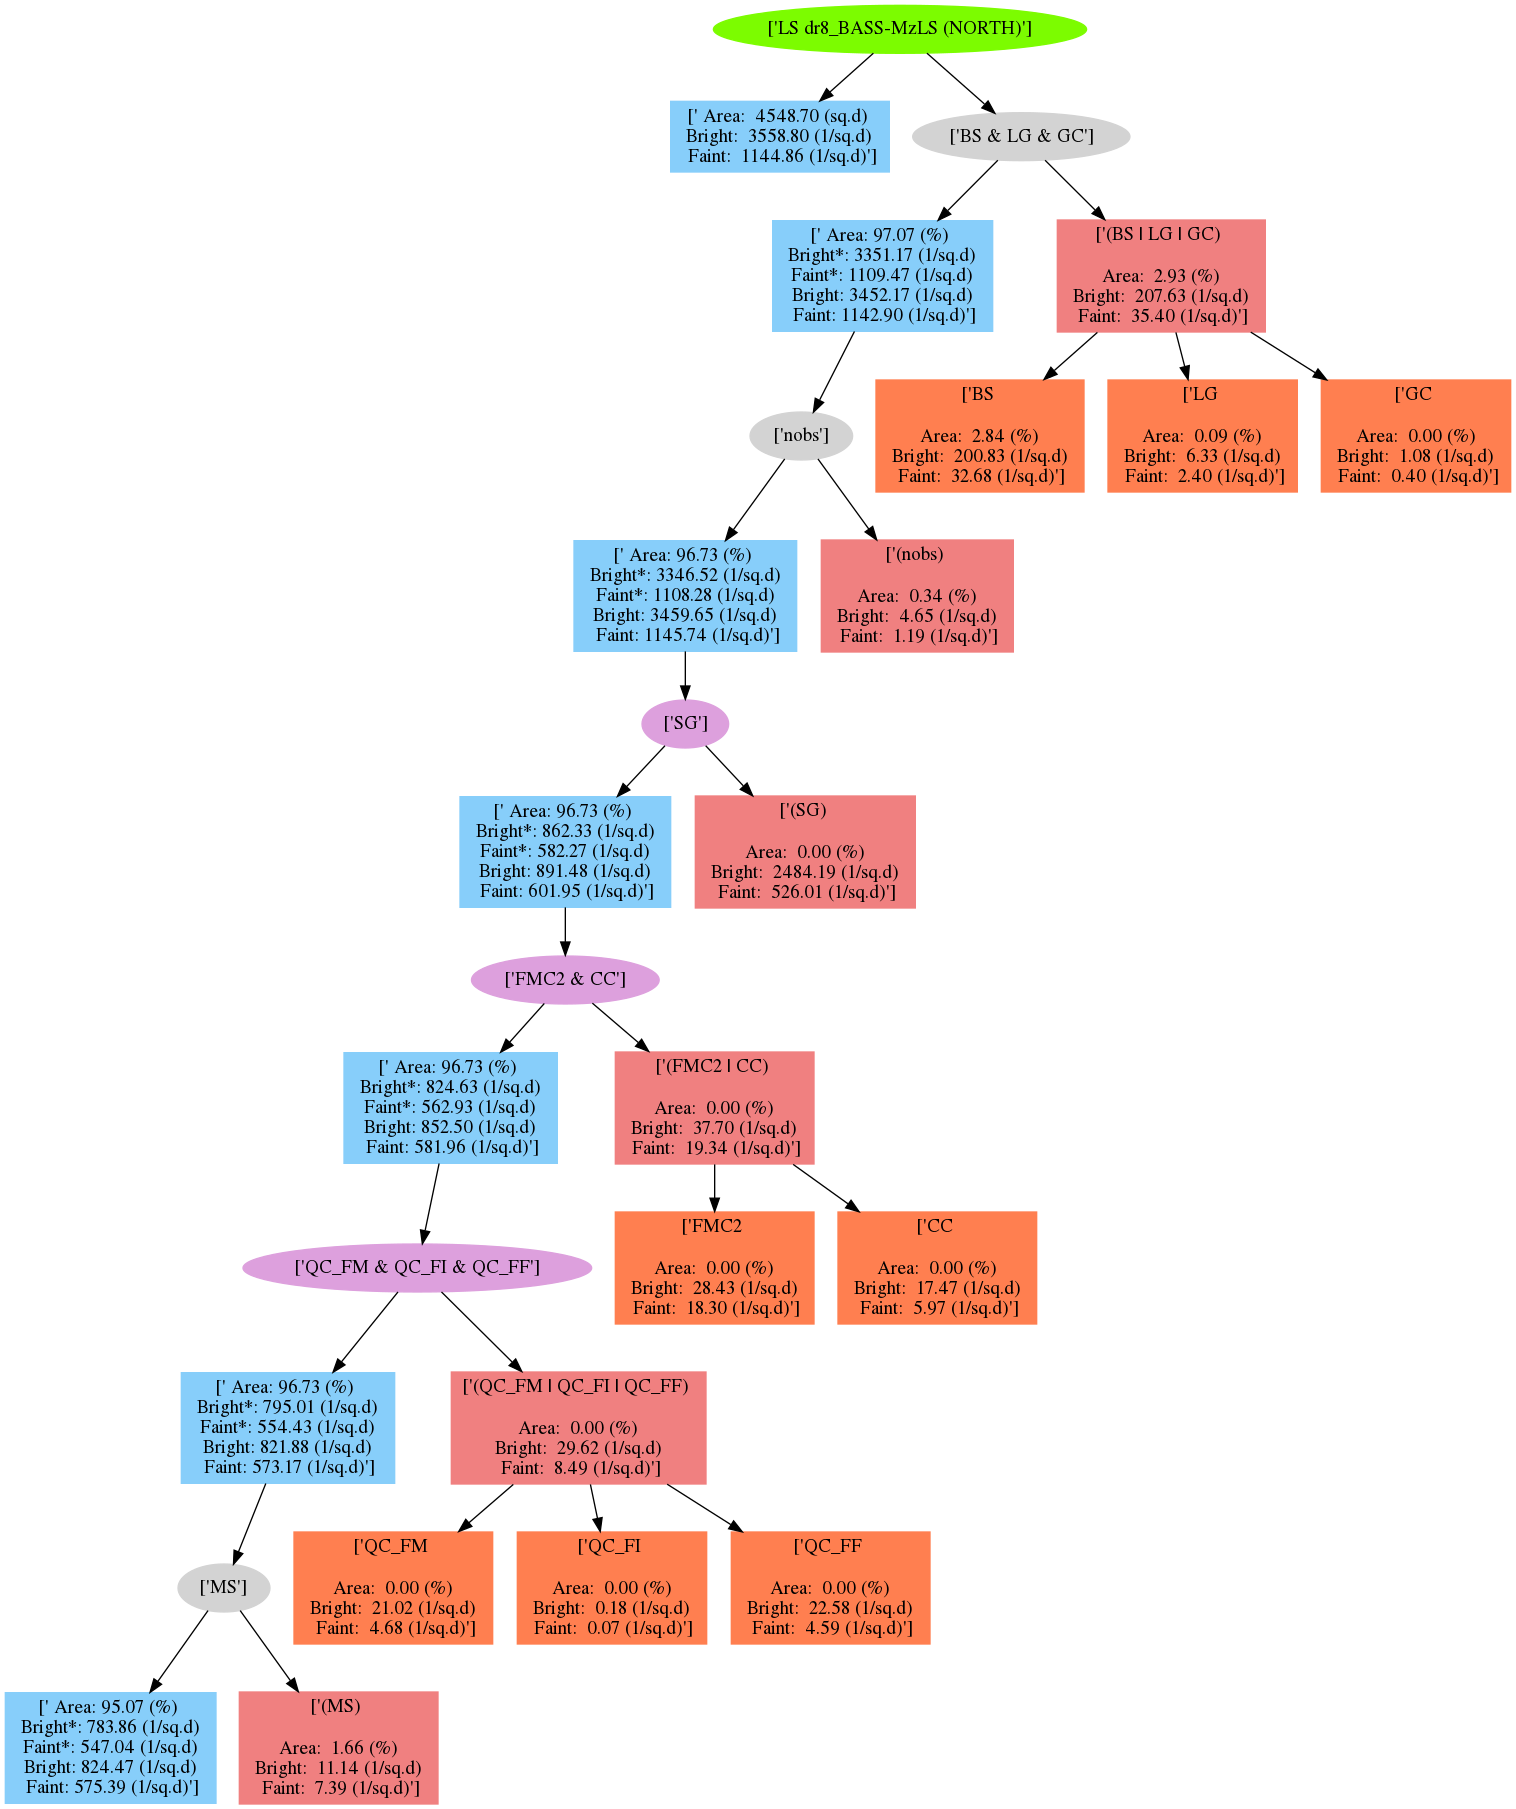

In [22]:
order = [['BS', 'LG', 'GC'], ['nobs'], ['SG'], ['FMC2', 'CC'], ['QC_FM', 'QC_FI', 'QC_FF'], ['MS']]


flowNominal, _, _ = flow(cat=cat, hpdict=hpdict0, bgsmask=bgsmask(), rancuts=rancuts, order=order, reg=region, 
             regcat=catinreg, regran=raninreg, file='%s/flow_main_nominal_%s' %(pathdir, flowTitle), dr=flowTitle, program='main')

flowNominal

Previous Cuts: (None)
Current Cuts: (SG)
Previous Cuts: (SG)
Current Cuts: (BS|LG|GC)
Previous Cuts: (SG|BS|LG|GC)
Current Cuts: (nobs)
Previous Cuts: (SG|BS|LG|GC|nobs)
Current Cuts: (QC_FM|QC_FI|QC_FF)
Previous Cuts: (SG|BS|LG|GC|nobs|QC_FM|QC_FI|QC_FF)
Current Cuts: (FMC2|CC)
Previous Cuts: (SG|BS|LG|GC|nobs|QC_FM|QC_FI|QC_FF|FMC2|CC)
Current Cuts: (MS)


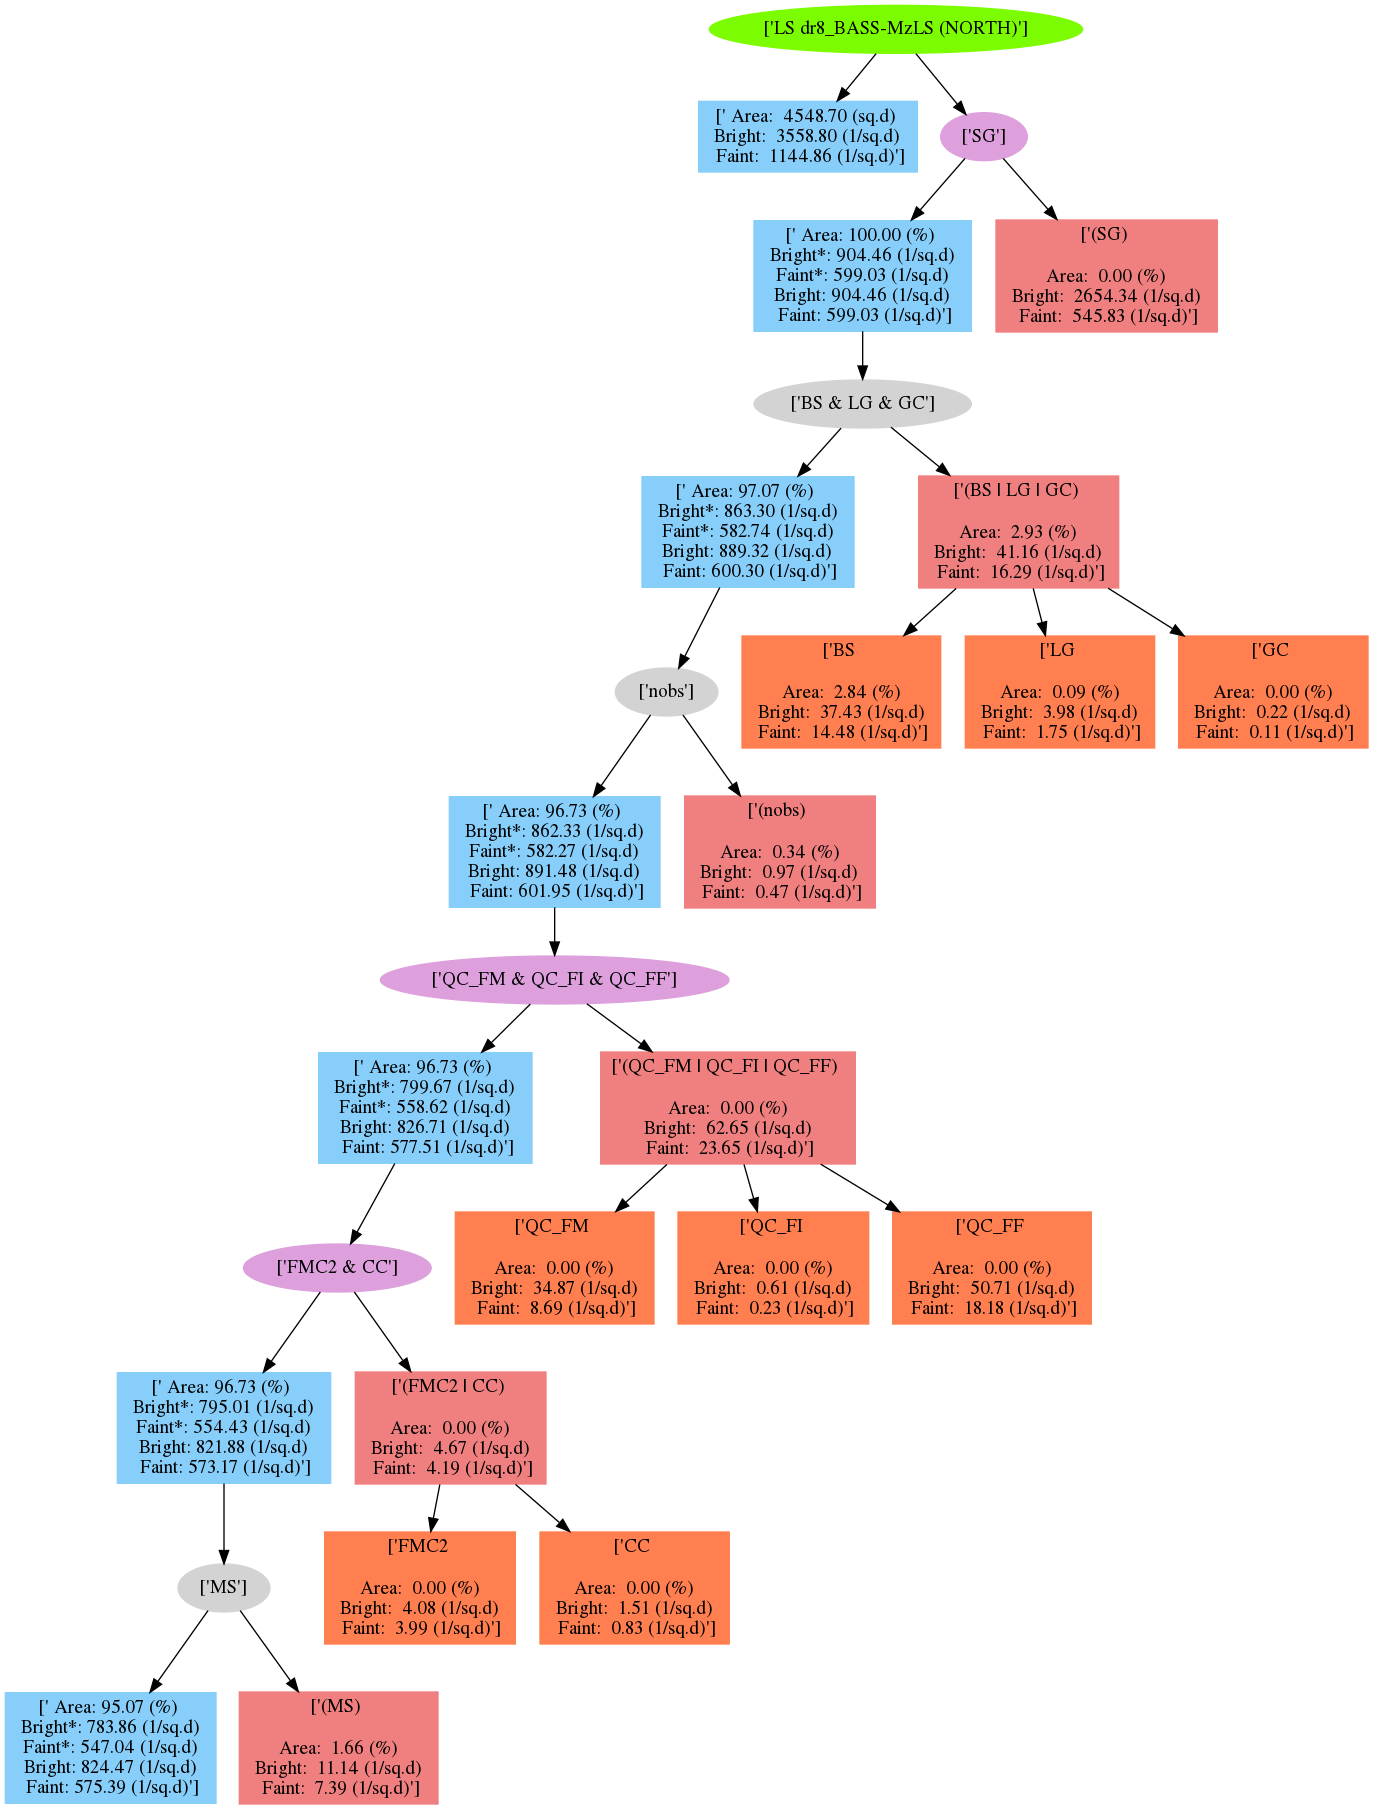

In [23]:
order = [ ['SG'], ['BS', 'LG', 'GC'], ['nobs'], ['QC_FM', 'QC_FI', 'QC_FF'], ['FMC2', 'CC'], ['MS']]

flowGalview, _, _ = flow(cat=cat, hpdict=hpdict0, bgsmask=bgsmask(), rancuts=rancuts, order=order, reg=region, 
             regcat=catinreg, regran=raninreg, file='%s/flow_main_galview_%s' %(pathdir,flowTitle), dr=flowTitle, program='main')

flowGalview

## 2D-stacks around Bright Stars and Medium Stars

Firs we do the stacking around the bright stars (`BS mask`) using BGS but `BS`. 

For the second stacking, we use BGS and do the stacking around the Medium Stars (`MS mask`).

In [20]:
#star catalogue
stars = np.load('/global/cscratch1/sd/qmxp55/pauline/stars_GAIA_TYCHO_13.npy')

In [21]:
hppix_stars = hp.ang2pix(nside,(90.-stars['DEC'])*np.pi/180.,stars['RA']*np.pi/180.,nest=True) # catalogue hp pixels array
if reg == 'svfields_fg': starsinreg = get_svfields_fg(stars['RA'], stars['DEC'])
elif reg == 'svfields_ij': starsinreg = get_svfields_ij(stars['RA'], stars['DEC'], survey=survey)
else: starsinreg = get_reg(reg=reg, hppix=hppix_stars)
#cstars = SkyCoord(stars['RA']*units.degree,stars['DEC']*units.degree, frame='icrs')
#galb_stars = cstars.galactic.b.value # galb coordinate
stars = stars[(starsinreg) & (stars['DEC'] > -25)]

In [22]:
#Dustin_radii's
mag = np.linspace(0, 20, 50)
BS_radii = []
new_BS_radii = []
for i,j in enumerate(mag):
    BS_radii.append([j, np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])
    new_BS_radii.append([j, 0.5 * np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])

In [23]:
bgsbutBS = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['BS'], bgsmask=bgsmask(), rlimit=20)

mag_bins_len: 2
8.00 < MAG < 12.00
MARK #1
MARK #2
mag_radii MAX: 98.43467880720439 mag_radii MIN: 29.01009464736186
mag MAX: 11.999996185302734 mag MIN: 8.000004768371582
d2d min=0.00134, d2d max=13.8
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-1.41, 1.18)
0 of inf in density ratio out of a total of 7556
Minimum density ratio = -4.73345, Maximum density ratio = 3.04594
----------------
12.00 < MAG < 13.00
MARK #1
MARK #2
mag_radii MAX: 29.010044635122284 mag_radii MIN: 21.357112467941665
mag MAX: 12.99999713897705 mag MIN: 12.000001907348633
d2d min=0.00169, d2d max=18.7
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-5.12, 0.0711)
4 of inf in density ratio out of a total of 7556
Minimum density ratio = -6.57907, Maximum density ratio = 0.49775
----------------


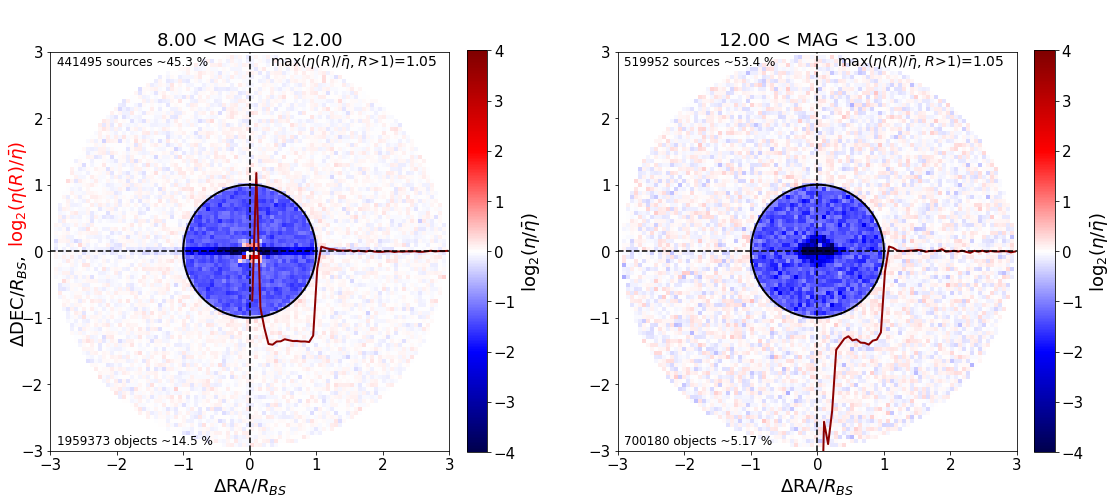

In [26]:
#
#bgslist = ['LG', 'GC', 'nobs', 'SG', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF']
    
# get BGS objects without BS bit set on
#bgsbutBS = np.ones_like(cat['RA'], dtype=bool)

#for key in bgslist:
#    keep = ((cat['BGSBITS'] & 2**(bgsmask()[key])) != 0)
#    bgsbutBS &= keep
#bgsbutBS &= cat['RMAG'] < 20
    
#%time bgsbutBS = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['BS'], bgsmask=bgsmask(), rlimit=20)
    
log = True
nbins = 101
    
    #radius = np.minimum(1800., 150. * 2.5**((11. - mag)/3.)) * 0.262/3600.
        
plt.figure(figsize=(18, 9))
#plt.title(r'%s %s' %('%s' %(dr), '%s' %(surveylab)), size=25)
plt.axis('off')
_ = overdensity(cat[bgsbutBS], stars, BS_radii, 'MAG', 35, density=False, 
                        magbins=[8,12, 13], radii_2=BS_radii, grid=[1,2], SR=[0., 400.], scaling=True, nbins=nbins, 
                               SR_scaling=3,logDenRat=[-4, 4], radii_bestfit=False, annulus=None, bintype='0', 
                                   filename='%s/2d_stack_BS_%s_%s' %(pathdir, dr, survey), log=log)


### Close up at bump for $\vec{r}/r_{BS} > 1$

mag_bins_len: 1
5.00 < MAG < 13.00
mag_radii MAX: 114.99567732556827 mag_radii MIN: 10.678754360164612
mag MAX: 12.99993896484375 mag MIN: 5.219666004180908
d2d min=0.129, d2d max=93.6
95652 95652 95652
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-3.79, 0.206)
52 of inf in density ratio out of a total of 4792
Minimum density ratio = -4, Maximum density ratio = 1.52811
----------------
30 30


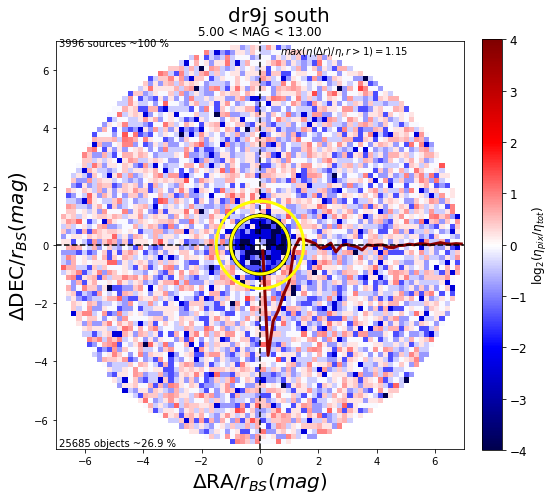

In [52]:
#
#
if True:
    bgsbutBS = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['BS'], bgsmask=bgsmask(), rlimit=20)

    log = True
    nbins = 81

    plt.figure(figsize=(8,8))
    plt.title(r'%s %s' %(dr, survey), size=20)
    plt.axis('off')
    d2d, d_ra2, d_dec2, annMask = overdensity(cat[bgsbutBS], stars, new_BS_radii, 'MAG', 35, density=False, 
                            magbins=[5,13], radii_2=None, grid=[1,1], SR=[0., 1000.], scaling=True, nbins=nbins, 
                                   SR_scaling=7,logDenRat=[-4, 4], radii_bestfit=False, annulus=[1.0, 1.5], bintype='0', 
                                       filename='%s/2d_stack_BS_%s_%s_1_1.5' %(pathdir, dr, survey), log=log)
    
    
    #
    #
    annmask = np.zeros_like(cat['RA'], dtype=bool)
    d2d2 = np.zeros_like(cat['RA'])
    #bgsbutBS objects in annulus. Boolean with size of entire catalogue
    annmask[np.where(bgsbutBS)] = annMask
    d2d2[np.where(bgsbutBS)] = d2d

    print(np.sum(annMask), np.sum(annmask))

In [53]:
#

if True:
    
    from postages_images import html_postages

    veto = {'BGS':(bgs_any),'Not BGS':(~bgs_any)}

    layer_list = ['%s-%s' %(dr, survey), '%s-%s-model' %(dr, survey), '%s-%s-resid' %(dr, survey)]

    masks = {'rmag<19':(BS_diff) & (bgsbutBS) & (cat['RMAG'] < 19), 'rmag>19':(BS_diff) & (bgsbutBS) & (cat['RMAG'] > 19)}

    idx = list(np.where(annmask))[0]
    print('sample size: %i' %(len(idx)))

    #
    html_postages(cat=cat, coord=[cat['RA'], cat['DEC']], idx=idx, notebook=True, savefile='%s/BGSbutBS_in_bump_5<G<13' %(pathdir), 
                  htmltitle='%s/BGSbutBS_in_bump_5<G<13' %(pathdir), veto=veto, grid=[5,6], m=4, radius=4/3600, 
                      comparison=None, layer_list=layer_list)

sample size: 30


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr9j-south_svfields_ij_0.1.0_draft_plots/BGSbutBS_in_bump_5<G<13.html
32.0 122


In [ ]:
#
if False:
    plt.figure(figsize=(10,5))

    plt.plot(np.transpose(BS_radii)[0], np.transpose(BS_radii)[1], lw=2, c='k', label='BS radii')
    plt.plot(np.transpose(new_BS_radii)[0], np.transpose(new_BS_radii)[1], lw=2, c='r', label='NEW BS radii')

    plt.legend()
    plt.grid()


In [ ]:
#
from QA import circular_mask_radii_func
from io_ import query_catalog_mask

BS_t = query_catalog_mask(cat['RA'], cat['DEC'], stars, BS_radii, nameMag='MAG', diff_spikes=False, 
                             length_radii=None, widht_radii=None, return_diagnostics=True, bestfit=False, log=False)
#
new_BS_t = query_catalog_mask(cat['RA'], cat['DEC'], stars, new_BS_radii, nameMag='MAG', diff_spikes=False, 
                             length_radii=None, widht_radii=None, return_diagnostics=True, bestfit=False, log=False)
#masking radius for each object cloosest stars in cat
mask_radii = circular_mask_radii_func(BS_t[1]['w1_source'], BS_radii, bestfit=False)
#masking radius reescaled for each object
mask_radii_res = BS_t[1]['d2d_source']/mask_radii
#
BS_diff = (BS_t[0]) & (~new_BS_t[0]) & (cat['RMAG'] < 20)
PSF = ((cat['TYPE'] == 'PSF') | (cat['TYPE'] == 'PSF ')) 
refcat = cat['REF_CAT']
if isinstance(np.atleast_1d(refcat)[0], str):
    LG = [(rc[0] == "L") if len(rc) > 0 else False for rc in refcat]
else:
    LG = [(rc.decode()[0] == "L") if len(rc) > 0 else False for rc in refcat]

print('objects within BS radii defs & r<20: \t %i (PSF) \t %i (no-PSF) \t %i (LSLGA)' 
      %(np.sum((BS_diff) & (PSF)), np.sum((BS_diff) & (~PSF)), np.sum((BS_diff) & (LG))))
print('objects within BS radii defs & r<20 & BGS: \t %i (PSF) \t %i (no-PSF) \t %i (LSLGA)' 
      %(np.sum((BS_diff) & (PSF) & (bgsbutBS)), np.sum((BS_diff) & (~PSF) & (bgsbutBS)), np.sum((BS_diff) & (LG))))


Total run time: 6.484529 sec
Total run time: 6.351680 sec
objects within BS radii defs & r<20: 	 3658 (PSF) 	 1742 (no-PSF) 	 34 (LSLGA)
objects within BS radii defs & r<20 & BGS: 	 45 (PSF) 	 1596 (no-PSF) 	 34 (LSLGA)


$\Delta \vec{r}/r_{BS}$

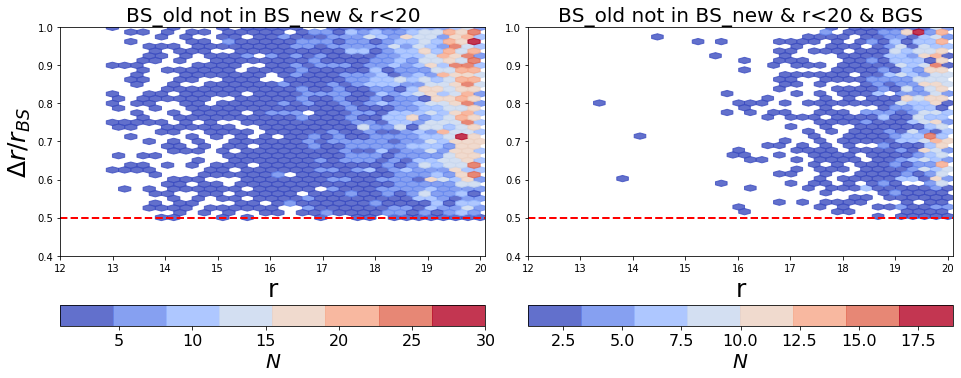

In [ ]:
#
rows, cols = 1, 2
coord = {'r':cat['RMAG'], '$\Delta r/r_{BS}$':mask_radii_res}
area = hpdict0['bgsarea_'+survey]

#debug = cat['RMAG'] < 16
masks = {'BS_old not in BS_new & r<20':(BS_diff), 'BS_old not in BS_new & r<20 & BGS':(BS_diff) & (bgsbutBS)}
hline, vline = 0.5, None
vmin, vmax = 1, None
    
fig    = plt.figure(figsize=(8*cols,6*rows))
gs     = gridspec.GridSpec(rows, cols, hspace=0.25, wspace=0.10)
cmap = plt.get_cmap('coolwarm', 8)
    
for i, key, val in zip(range(len(masks)), masks.keys(), masks.values()):
        
    if (i%cols==0): ylab=True
    else: ylab = False
        
    hexbin(coord=coord, catmask=(val), n=i, bins=None, title=key, cmap=cmap, 
               ylab=ylab, xlab=True, vline=vline, hline=hline, fig=fig, gs=gs, vmin=vmin, vmax=vmax, mincnt=1, fmcline=False, 
                   file='%s/r_mask_radii_BSold_not_BSnew_%s' %(pathdir, survey), fracs=False, area=area, cbar='horizontal',
                      xlim=[12, 20.1], ylim=[0.4, 1.0], gridsize=(30,20))
    

In [ ]:
#
from postages_images import html_postages

veto = {'BGS':(bgs_any),'Not BGS':(~bgs_any)}

layer_list = ['%s-%s' %(dr, survey), '%s-%s-model' %(dr, survey), '%s-%s-resid' %(dr, survey)]

masks = {'rmag<19':(BS_diff) & (bgsbutBS) & (cat['RMAG'] < 19), 'rmag>19':(BS_diff) & (bgsbutBS) & (cat['RMAG'] > 19)}

for key, val in zip(masks.keys(), masks.values()):

    idx = list(np.where(val))[0]
    print('sample size: %i' %(len(idx)))
        
    #
    html_postages(cat=cat, coord=[cat['RA'], cat['DEC']], idx=idx, notebook=True, savefile=pathdir+'/diff_BS_larger_smaller_radii_%s' %(key), 
              htmltitle='/diff_BS_larger_smaller_radii_%s' %(key), veto=veto, grid=[4,6], m=4, radius=4/3600, 
                  comparison=None, layer_list=layer_list)

sample size: 533


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr9j-south_svfields_ij_0.1.0_draft_plots/diff_BS_larger_smaller_radii_rmag<19.html
32.0 122


sample size: 1108


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr9j-south_svfields_ij_0.1.0_draft_plots/diff_BS_larger_smaller_radii_rmag>19.html
32.0 122


### Medium BS

In [14]:
from io_ import get_msmask
from io_ import get_bsmask
from io_ import search_around

#load mask sources objects from SWEEPS DR8
masksources = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr8/dr8_sweep_whole_maskbitsources.npy')

In [15]:
%time hppix_masksources = hp.ang2pix(nside,(90.-masksources['DEC'])*np.pi/180.,masksources['RA']*np.pi/180.,nest=True) # catalogue hp pixels array
if reg == 'svfields_fg': masksourcesinreg = get_svfields_fg(masksources['RA'], masksources['DEC'])
elif reg == 'svfields_ij': masksourcesinreg = get_svfields_ij(masksources['RA'], masksources['DEC'], survey=survey)
else: masksourcesinreg = get_reg(reg=reg, hppix=hppix_masksources)

#cstars = SkyCoord(stars['RA']*units.degree,stars['DEC']*units.degree, frame='icrs')
#galb_stars = cstars.galactic.b.value # galb coordinate
masksources = masksources[(masksourcesinreg) & (masksources['DEC'] > -25)]

CPU times: user 11.5 s, sys: 1.75 s, total: 13.2 s
Wall time: 13 s


In [16]:
#get the medium bright stars
%time starsMS = get_msmask(masksources)

1669 nearby objects
3366809 Medium Bright Stars
CPU times: user 4.32 s, sys: 474 ms, total: 4.8 s
Wall time: 4.17 s


In [17]:
%time hppix_starsMS = hp.ang2pix(nside,(90.-starsMS['DEC'])*np.pi/180.,starsMS['RA']*np.pi/180.,nest=True) # catalogue hp pixels array
if reg == 'svfields_fg': starsMSinreg = get_svfields_fg(starsMS['RA'], starsMS['DEC'])
elif reg == 'svfields_ij': starsMSinreg = get_svfields_ij(starsMS['RA'], starsMS['DEC'], survey=survey)
else: starsMSinreg = get_reg(reg=reg, hppix=hppix_starsMS)

#cstars = SkyCoord(stars['RA']*units.degree,stars['DEC']*units.degree, frame='icrs')
#galb_stars = cstars.galactic.b.value # galb coordinate
starsMS = starsMS[(starsMSinreg) & (starsMS['DEC'] > -25)]

CPU times: user 422 ms, sys: 19 ms, total: 441 ms
Wall time: 223 ms


In [ ]:
#
log = True
nbins = 101

bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)
#bgsbutBS = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['BS'], bgsmask=bgsmask(), rlimit=20)
#print(np.sum((bgsbutBS) & (~BS_t[0])))
#print(np.sum((bgs_any) & (~BS_t[0])))
        
plt.figure(figsize=(8, 8))
plt.title(r'%s %s' %(dr, survey), size=20)
plt.axis('off')

#_ = overdensity(cat[(bgs_any) & (~BS_t[0])], starsMS, new_BS_radii, 'MAG', 35, density=False, 
_ = overdensity(cat[(bgs_any)], starsMS, new_BS_radii, 'MAG', 35, density=False, 
                        magbins=[13,16], radii_2=new_BS_radii, grid=[1,1], SR=[0., 500], scaling=True, nbins=nbins, 
                               SR_scaling=7,logDenRat=[-4, 4], radii_bestfit=False, annulus=[1,2], bintype='0', 
                                   filename='%s/2d_stack_MS_%s_%s' %(pathdir, dr, survey), log=log)

mag_bins_len: 1
13.00 < MAG < 16.00
MARK #1


### Differences in magnitude for GAIA and Tycho2

3998 nearby objects
974002 Bright Stars
G2 970004
T2 3998
b'G2' 73126951
b'L2' 218852
b'T2' 3998


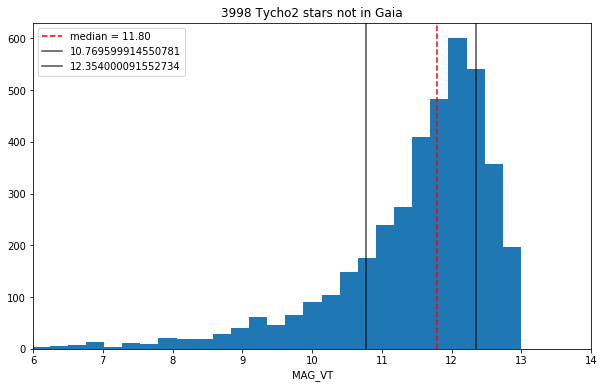

152367 nearby objects
152367 152367


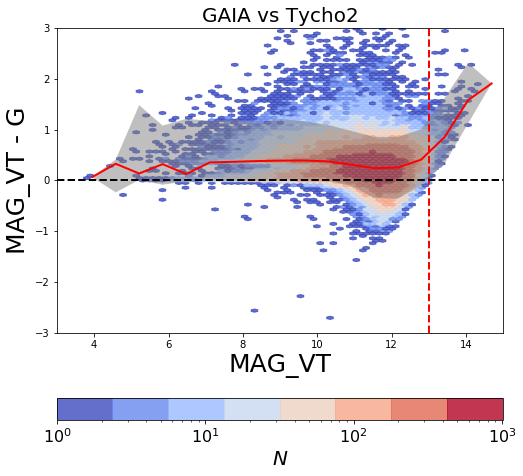

In [32]:
#
if True:
    
    starsBS = get_bsmask(masksources)

    hppix_starsBS = hp.ang2pix(nside,(90.-starsBS['DEC'])*np.pi/180.,starsBS['RA']*np.pi/180.,nest=True) # catalogue hp pixels array
    if reg == 'svfields_fg': starsBSinreg = get_svfields_fg(starsBS['RA'], starsBS['DEC'])
    elif reg == 'svfields_ij': starsBSinreg = get_svfields_ij(starsBS['RA'], starsBS['DEC'], survey=survey)
    else: starsBSinreg = get_reg(reg=reg, hppix=hppix_starsBS)

    #cstars = SkyCoord(stars['RA']*units.degree,stars['DEC']*units.degree, frame='icrs')
    #galb_stars = cstars.galactic.b.value # galb coordinate
    starsBS = starsBS[(starsBSinreg) & (starsBS['DEC'] > -25)]

    #
    for i in set(starsBS['REF_CAT'][:10000]):
        print(i, np.sum(starsBS['REF_CAT'] == i))

    for i in set(masksources['REF_CAT'][:100000]):    
        print(i, np.sum(masksources['REF_CAT'] == i))

    mask = starsBS['REF_CAT'] == 'T2'
    
    fig = plt.figure(figsize=(10, 6))
    plt.title(r'%i Tycho2 stars not in Gaia' %(np.sum(mask))) 
    plt.hist(starsBS['MAG'][mask], 50)
    
    xmin, xmax = np.percentile(starsBS['MAG'][mask], (20, 80))
    #plt.axvline(13)
    xmedian = np.median(starsBS['MAG'][mask])
    plt.axvline(xmedian, ls='--', color='r', label='median = %.2f' %(xmedian))
    plt.axvline(xmin, color='k', alpha=0.7, label=xmin)
    plt.axvline(xmax, color='k', alpha=0.7, label=xmax)
    plt.xlabel(r'MAG_VT')
    plt.xlim(6,14)
    plt.legend()
    plt.show()

    ##
    #
    magG = np.zeros_like(masksources['RA'])
    magT = np.zeros_like(masksources['RA'])
    ingaia = (masksources['REF_CAT'] == b'G2') & (masksources['G'] <= 13)
    intycho = (masksources['REF_CAT'] == b'T2')

    # get MAG_VT mag from Tycho
    path = '/global/homes/q/qmxp55/DESI/matches/'
    tycho = fitsio.read(path+'tycho2.fits')
    idx2, idx1, d2d, d_ra, d_dec = search_around(masksources['RA'][ingaia], masksources['DEC'][ingaia], tycho['RA'], tycho['DEC'], search_radius=0.3)


    magT = tycho['MAG_VT'][idx1]
    magG = masksources['G'][ingaia][idx2]
    #magT[np.where(intycho)] = tycho['MAG_VT'][idx1]
    #magG[np.where(ingaia)] = masksources['G'][ingaia]

    print(len(magT), len(magG))

    ####

    #
    coord = {'MAG_VT':magT, 'MAG_VT - G':(magT - magG)}

    fig    = plt.figure(figsize=(8*1,8*1))
    gs     = gridspec.GridSpec(1, 1, hspace=0.15, wspace=0.10)
    cmap = plt.get_cmap('coolwarm', 8)

    ax, _, _ = hexbin(coord=coord, catmask=None, n=0, bins='log', title='GAIA vs Tycho2', cmap=cmap, 
                   ylab=True, vline=13, hline=None, fig=fig, gs=gs, vmin=None, vmax=None, mincnt=1, 
                       file=None, fracs=False, area=None, cbar='horizontal', xlim=[3, 15], ylim=[-3, 3], showmedian=True)

    ax.axhline(0, lw=2, ls='--', c='k')
    

In [37]:
#
def rad(m):
    return 39.3*2.5**((11-m)/3)

print(rad(3)-rad(3.4))
print(rad(13)-rad(13.4))

52.03297590631598
2.45364636424787


## Grr vs g-z: bgsbutSG

In [17]:
#bgslist = ['BS', 'LG', 'GC', 'nobs', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF', 'QC_IVAR']
    
## get BGS objects without BS bit set on
#bgsbutSG = np.ones_like(cat['RA'], dtype=bool)

#for key in bgslist:
#    keep = ((cat['BGSBITS'] & 2**(bgsmask()[key])) != 0)
#    bgsbutSG &= keep
#bgsbutSG &= cat['RMAG'] < 20

bgsbutSG = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['SG'], bgsmask=bgsmask(), rlimit=20)

finite = np.ones_like(cat['RMAG'], dtype='?')
for i in ['RMAG', 'GMAG', 'ZMAG','FLUX_R', 'RFIBERMAG']:
    finite &= np.isfinite(cat[i])
    

In [18]:
Ared = hpdict['bgsarea_'+reg]

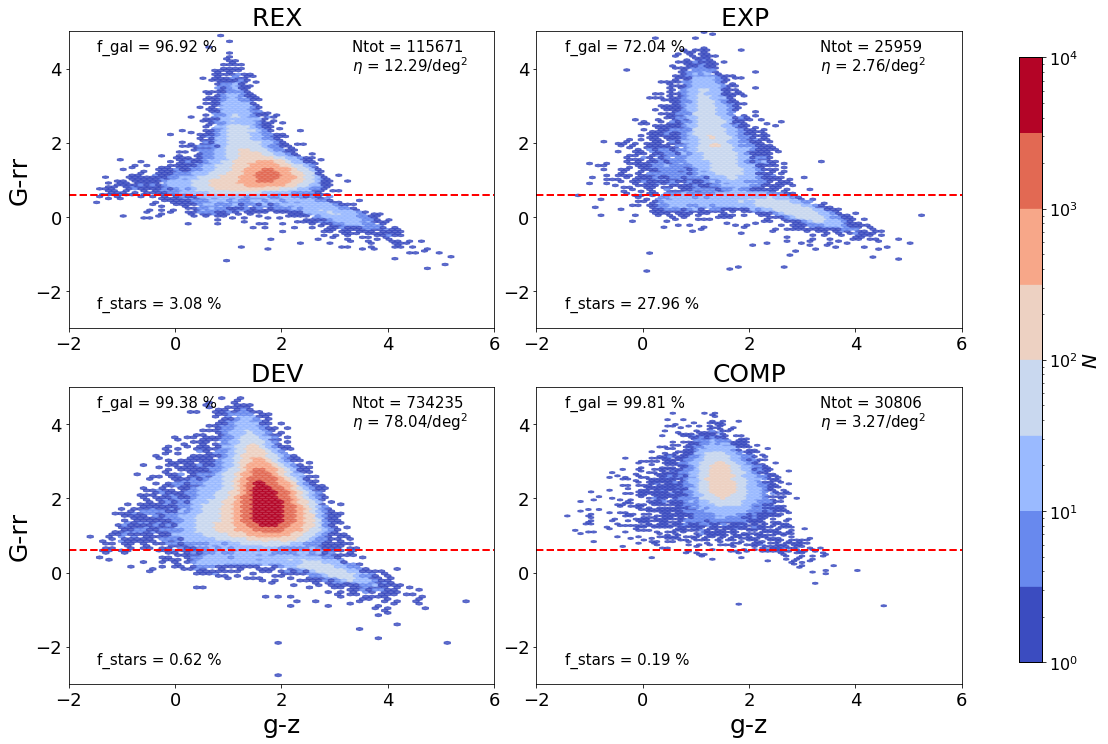

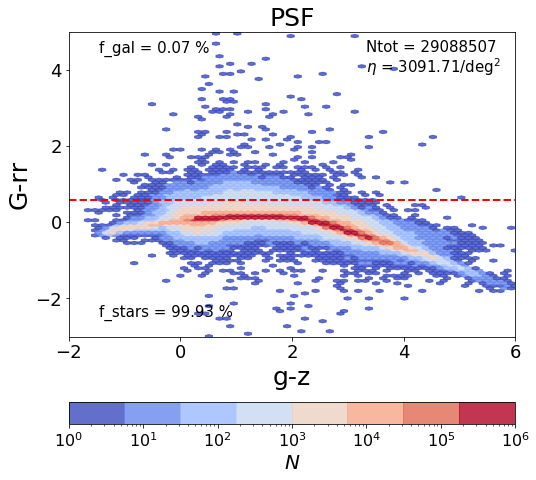

In [19]:
#
Grr = cat['G'] - flux_to_mag(cat['FLUX_R'])
coord = {'g-z':cat['GMAG'] - cat['ZMAG'], 'G-rr':Grr}
PSF = (cat['TYPE'] == 'PSF ') | (cat['TYPE'] == 'PSF') 
#if dr[:3] == 'dr9': morphos = ['REX', 'EXP', 'DEV', 'SER']
#else: morphos = ['REX ', 'EXP ', 'DEV ', 'COMP']
rows, cols = 2, 2
#debug = cat['RMAG'] < 16
mask = (catinreg) & (bgsbutSG) & (finite) #& (debug)
hline, vline = 0.6, None
vmin, vmax = 1, None
    
fig    = plt.figure(figsize=(8*cols,6*rows))
gs     = gridspec.GridSpec(rows, cols, hspace=0.2, wspace=0.10)
cmap = plt.get_cmap('coolwarm', 8)
    
for i, morpho in enumerate(morphos):
        
    if (i%cols==0): ylab=True
    else: ylab = False
    if (morpho == PSF): 
        vmax, cbar = None, 'vertical'
    else:
        vmax, cbar = 10000, 'panel'
        
    if i < 2: xlab = False
    else: xlab = True
        
    morphomask = cat['TYPE'] == morpho
    hexbin(coord=coord, catmask=((mask) & (morphomask)), n=i, bins='log', title=morpho, cmap=cmap, 
               ylab=ylab, xlab=xlab, vline=vline, hline=hline, fig=fig, gs=gs, vmin=vmin, vmax=vmax, mincnt=1, 
                   file='%s/gz_Grr_bgsbutSG_hexbin_extended_%s' %(pathdir, survey), fracs=True, area=Ared, cbar=cbar)

fig    = plt.figure(figsize=(8*1,8*1))
gs     = gridspec.GridSpec(1, 1, hspace=0.15, wspace=0.10)

hexbin(coord=coord, catmask=((mask) & (PSF)), n=0, bins='log', title='PSF', cmap=cmap, 
               ylab=True, vline=vline, hline=hline, fig=fig, gs=gs, vmin=None, vmax=1000000, mincnt=1, 
                   file='%s/gz_Grr_bgsbutSG_hexbin_psf_%s' %(pathdir, survey), fracs=True, area=Ared, cbar='horizontal')
        

## rmag vs rfibmag: bgsbutFMC

In [20]:
#bgslist = ['BS', 'LG', 'GC', 'nobs', 'SG', 'CC', 'QC_FM', 'QC_FI', 'QC_FF', 'QC_IVAR']
    
## get BGS objects without BS bit set on
#bgsbutFMC2 = np.ones_like(cat['RA'], dtype=bool)

#for key in bgslist:
#    keep = ((cat['BGSBITS'] & 2**(bgsmask()[key])) != 0)
#    bgsbutFMC2 &= keep
#bgsbutFMC2 &= cat['RMAG'] < 20

bgsbutFMC2 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['FMC2'], bgsmask=bgsmask(), rlimit=20)


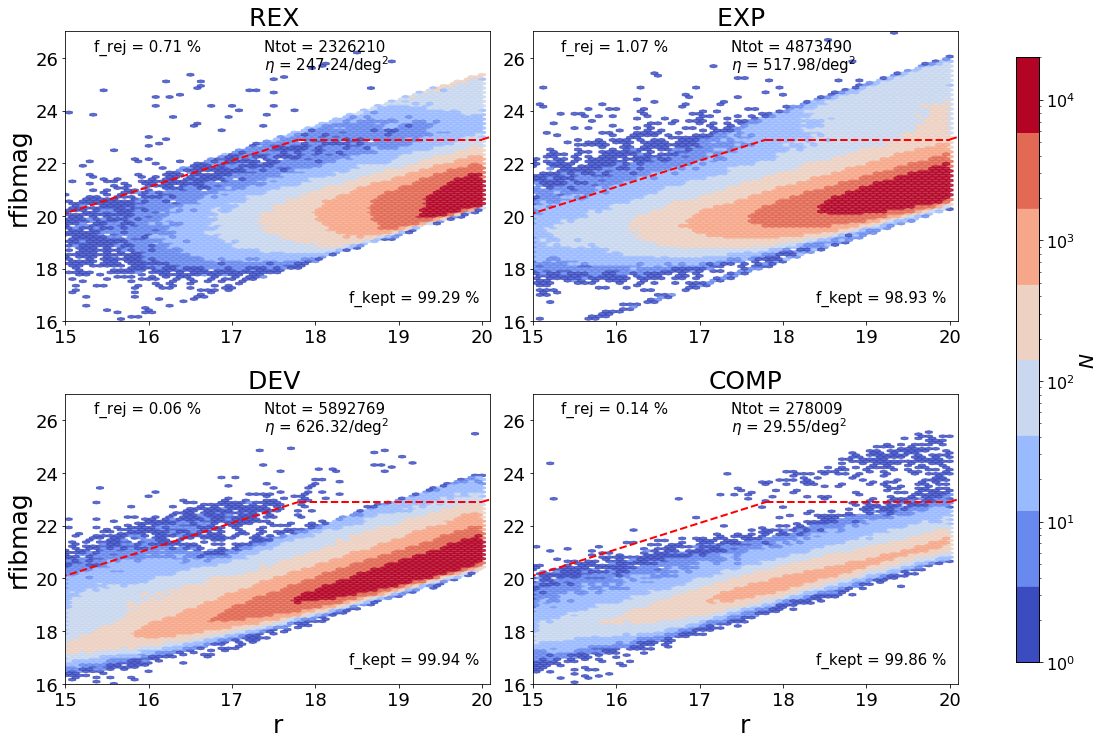

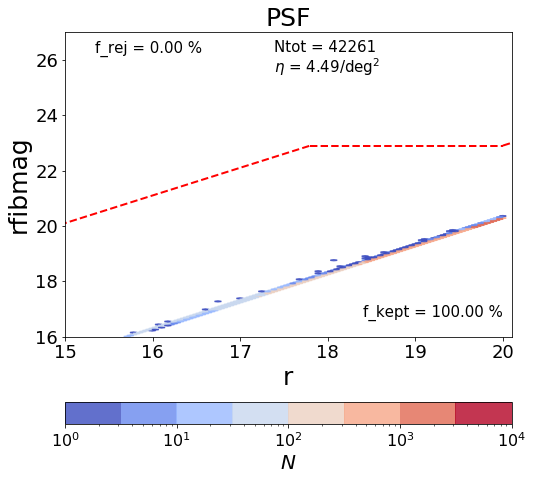

In [21]:
#
rows, cols = 2, 2
coord = {'r':cat['RMAG'], 'rfibmag':cat['RFIBERMAG']}

#debug = cat['RMAG'] < 16
mask = (catinreg) & (bgsbutFMC2) & (finite) #& (debug)
hline, vline = None, None
vmin, vmax = 1, 200
    
fig    = plt.figure(figsize=(8*cols,6*rows))
gs     = gridspec.GridSpec(rows, cols, hspace=0.25, wspace=0.10)
cmap = plt.get_cmap('coolwarm', 8)
    
for i, morpho in enumerate(morphos):
        
    if (i%cols==0): ylab=True
    else: ylab = False
    if morpho == PSF: 
        vmax, cbar = None, 'vertical'
    else:
        vmax, cbar = 20000, 'panel'
        
    if i < 2: xlab = False
    else: xlab = True
        
    morphomask = cat['TYPE'] == morpho
    hexbin(coord=coord, catmask=((mask) & (morphomask)), n=i, bins='log', title=morpho, cmap=cmap, 
               ylab=ylab, xlab=xlab, vline=vline, hline=hline, fig=fig, gs=gs, vmin=vmin, vmax=vmax, mincnt=1, fmcline=True, 
                   file='%s/r_rfibmag_bgsbutFMC2_hexbin_extended_%s' %(pathdir, survey), fracs=False, area=Ared, cbar=cbar)
    
    
fig    = plt.figure(figsize=(8*1,8*1))
gs     = gridspec.GridSpec(1, 1, hspace=0.15, wspace=0.10)

hexbin(coord=coord, catmask=((mask) & (PSF)), n=0, bins='log', title='PSF', cmap=cmap, 
               ylab=True, vline=vline, hline=hline, fig=fig, gs=gs, vmin=None, vmax=10000, mincnt=1, fmcline=True,
                   file='%s/r_rfibmag_bgsbutFMC2_hexbin_psf_%s' %(pathdir, survey), fracs=False, area=Ared, cbar='horizontal')
        

## g-r vs r-z: bgsbutCC

In [22]:

bgsbutCC = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['CC'], bgsmask=bgsmask(), rlimit=20)


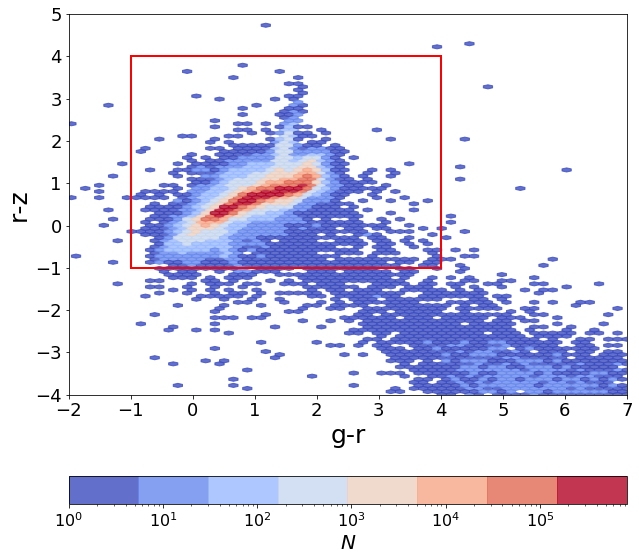

In [23]:
#
import matplotlib.patches as patches

coord = {'g-r':cat['GMAG'] - cat['RMAG'], 'r-z':cat['RMAG'] - cat['ZMAG']}
mask = (catinreg) & (bgsbutCC) & (finite) # & (cat['RMAG'] < 14)

fig   = plt.figure(figsize=(10,10))
gs     = gridspec.GridSpec(1, 1, hspace=0.15, wspace=0.10)


hexbin(coord=coord, catmask=mask, n=0, bins='log', title=None, cmap=cmap, 
               ylab=True, vline=None, hline=None, fig=fig, gs=gs, xlim=(-2, 7), ylim=(-4, 5), 
                   vmin=None, vmax=None, mincnt=1, fmcline=False,
                       file=None, fracs=False, area=Ared, cbar='horizontal')

plt.plot(np.linspace(-1, 4, 3), np.full(3, -1), lw=2, c='r')
plt.plot(np.linspace(-1, 4, 3), np.full(3, 4), lw=2, c='r')

plt.plot(np.full(3, -1), np.linspace(-1, 4, 3), lw=2, c='r')
plt.plot(np.full(3, 4), np.linspace(-1, 4, 3), lw=2, c='r')

file='%s/gr_rz_bgsbutCC_hexbin_%s' %(pathdir, survey)
fig.savefig(file, bbox_inches = 'tight', pad_inches = 0)



## Venn diagrams: QCs

In [29]:
from QA import plot_venn3

In [30]:
# get BGS but QCs
bgsbutQCs = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['QC_FM', 'QC_FI', 'QC_FF'], bgsmask=bgsmask(), rlimit=20)
FM = ((cat['BGSBITS'] & 2**(11)) == 0) #rejects by FM
FI = ((cat['BGSBITS'] & 2**(12)) == 0) #rejects by FI
FF = ((cat['BGSBITS'] & 2**(13)) == 0) #rejects by FF
area = hpdict0['bgsarea_'+survey]

In [33]:
8.83+5.27

14.1

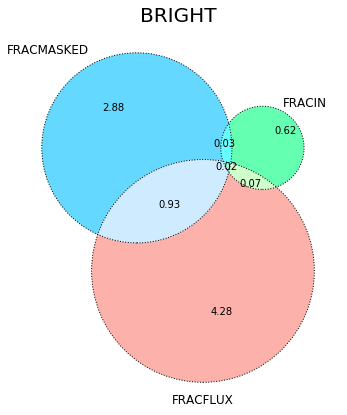

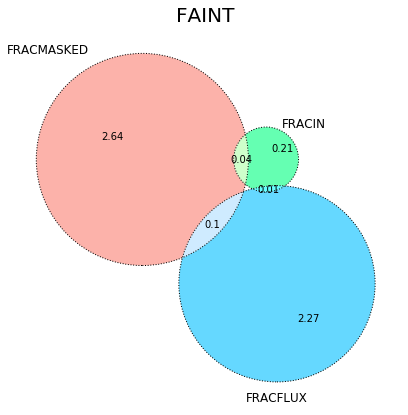

In [32]:
#
keepB = (bgsbutQCs) & (cat['RMAG'] < 19.5)
keepF = (bgsbutQCs) & (cat['RMAG'] > 19.5) & (cat['RMAG'] < 20)
plot_venn3(A=(keepB & FM), B=(keepB & FI), C=(keepB & FF), norm=area, 
           labels=['FRACMASKED', 'FRACIN', 'FRACFLUX'], file=pathdir+'/venn_QCs_bright_%s' %(survey), title='BRIGHT', colors = ['deepskyblue', 'springgreen', 'salmon'])
plot_venn3(A=(keepF & FF), B=(keepF & FI), C=(keepF & FM), norm=area, 
           labels=['FRACMASKED', 'FRACIN', 'FRACFLUX'], file=pathdir+'/venn_QCs_faint_%s' %(survey), title='FAINT', colors = ['salmon' ,'springgreen', 'deepskyblue'])


# AEN vs G-rr star-galaxy classification in GAIA

Tractor force to fit as PSF the GAIA objects that satisfy the following conditions:

* For $G<19$: astrometric_excess_noise $< 10^{0.5}$, 

* For $G≥19$: astrometric_excess_noise $ < 10^{0.5+0.2(G−19)}$.
    
G is the GAIA photometric $G$-band and the astrometric excess noise ($AEN$) is the...
Those PSF that are in GAIA are treated as Stars according to TRACTOR and the GAIA objects that do not fulfill that condition are treated as GALAXIES. This is different to the way we do star-galaxy separation for BGS, we use GAIA but rather than look at the $AEN$ we look at the colour distribution $G-rr$.

The PSF GAIA objects (from above definition) are treated differently than other PSF objects and they have a local fitting, the problem is that maybe those are not stars and might be galaxies instead that photometry is being altered by this local fitting.

Here we are going to find out what are the differences between our star-galaxy classification and the one above for GAIA objects.
We're going to:

* $Grr$ distributions for $Grr$ class and $AEN$ class:
    * All
    * TRACTOR PSF
    * TRACTOR No PSF
* Heat maps
* Venn diagram's
* Galleries of mismatches divided in `TRACTOR PSF` and `TRACTOR non-PSF`:
    * Stars with $Grr$ class and Galaxies with $AEN$ class
    * Galaxies with $Grr$ class and Stars with $AEN$ class

In [20]:
inGAIA = (cat['REF_CAT'] == 'G2') & (cat['RMAG'] < 20)
grr_gal = ((cat['BGSBITS'] & 2**(6)) != 0) & (cat['RMAG'] < 20)
grr_stars = ((cat['BGSBITS'] & 2**(6)) == 0) & (cat['RMAG'] < 20)
AEN_star, AEN_gal = gaiaAEN(inGAIA=inGAIA, size=len(cat['RA']), G=cat['G'], AEN=cat['AEN'], dr=dr)
PSF = (cat['TYPE'] == 'PSF ') | (cat['TYPE'] == 'PSF')

#inGAIA2 = (cat['G'] != 0)

In [32]:
area = hpdict_tmp['bgsarea_'+survey]
area

9401.059466666666

In [35]:
ff = (grr_gal) & (AEN_star)
print(np.sum(ff)/area)

for i in set(cat['TYPE'][bgs_any][:1000]):
    fg = (ff) & (cat['TYPE'] == i)
    print(i, np.round(np.sum(fg)/area, 1))

5.005712405804589
EXP  0.0
PSF  5.0
COMP 0.0
REX  0.0
DEV  0.0


In [34]:
for i in set(cat['TYPE'][bgs_any][:1000]):
    fg = (bgs_any) & (cat['TYPE'] == i)
    print(i, np.round(np.sum(fg)/area, 1))

EXP  513.6
PSF  4.6
COMP 30.5
REX  245.7
DEV  628.7


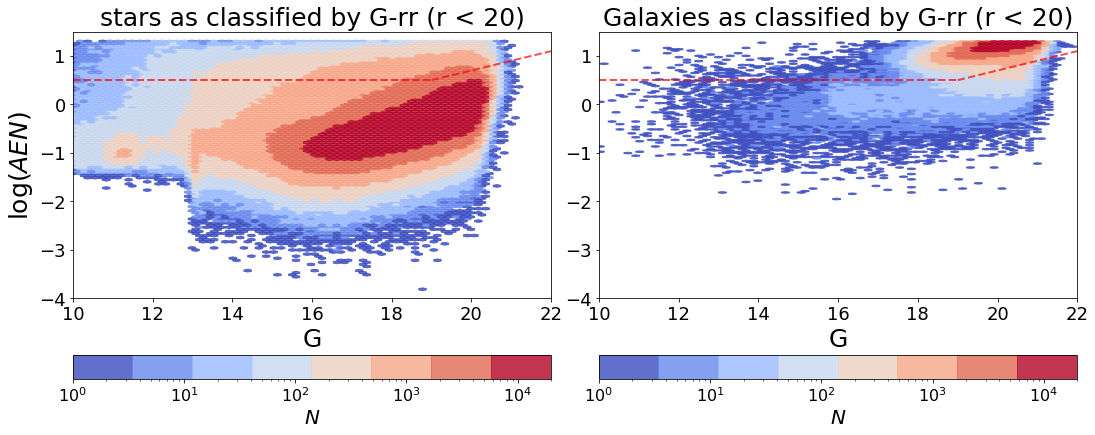

In [36]:
#
coord = {'G':cat['G'], r'$\log(AEN)$':np.log10(cat['AEN'])}
#masks = [(grr_stars) & (inGAIA) & (cat['RMAG'] < 14), (grr_gal) & (inGAIA) & (cat['RMAG'] < 14)]
masks = [(grr_stars) & (inGAIA), (grr_gal) & (inGAIA)]
titles = ['stars as classified by G-rr (r < 20)', 'Galaxies as classified by G-rr (r < 20)']
vmin, vmax = 1, None
    
fig    = plt.figure(figsize=(9*len(masks), 7))
gs     = gridspec.GridSpec(1, len(masks),hspace=0.1,wspace=0.10)
cmap = plt.get_cmap('coolwarm', 8)
xlim=[10, 22]
ylim=[-4, 1.5]

for i, mask in enumerate(masks):
        
    #if (i%len(masks)==0): xlab=True
    #else: xlab = False
    #if morpho == 'PSF ': vmax = None
        
    #morphomask = cat['TYPE'] == morpho
    hexbin(coord=coord, catmask=mask, n=i, bins='log', title=titles[i], cmap=cmap, xlab=True,
               ylab=True if i == 0 else False, vline=None, hline=None, fig=fig, gs=gs, vmin=1, vmax=20000, mincnt=1, fmcline=False, 
                   file=None, area=None, xlim=xlim, ylim=ylim, cbar='horizontal')
    
    #if i == 0:
    #    x, y = coord.keys()
    #    mask1 = (gaia_star) & (dr8_gama) & (dr8_z > 0.002) & (bgs)
    #    mask2 = (gaia_star) & (dr8_gama) & (dr8_z > 0.002) & (~bgs)
    #    plt.scatter(coord[x][mask2], coord[y][mask2], s=2, c='royalblue', label=r'Not in BGS')
    #    plt.scatter(coord[x][mask1], coord[y][mask1], s=2, c='k', label=r'in BGS')
    #    plt.legend()
    
    x_ = np.linspace(19, xlim[1], 4)
#     plt.plot(np.linspace(xlim[0], 18, 3), np.full(3, 0.5), color='r', ls='-', lw=2)
#     plt.plot(np.full(3, 18), np.linspace(ylim[0], 0.5, 3), color='r', ls='-', lw=2)
#     plt.plot(x_, 0.5 + 0.2*(x_ - 19.), color='r', ls='--', lw=2, alpha=0.7)
#     plt.plot(np.linspace(18,19,3), np.full(3, 0.5), color='r', ls='--', lw=2, alpha=0.7)

    plt.plot(x_, 0.5 + 0.2*(x_ - 19.), color='r', ls='--', lw=2, alpha=0.7)
    plt.plot(np.linspace(10,19,3), np.full(3, 0.5), color='r', ls='--', lw=2, alpha=0.7)

file = pathdir+'/G_logAEN'
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)

* How many galaxies (i.e. G-rr > 0.6) that are AEN stars? Are these real galaxies?
* How many SDSS & GAMA "truth" galaxies are AEN star? plot SDSS & GAMA galaxies on top of above plot.
    * how many of above in G-rr > 0.6?
    * how many of above in G-rr < 0.6?
    

In [26]:
#
area = hpdict0['bgsarea_'+survey]
BS = ((cat['BGSBITS'] & 2**(0)) != 0)
gal_in_aenstar = (inGAIA) & (grr_gal) & (cat['G'] < 18)*(np.log10(cat['AEN']) < 0.5)
print('G-rr > 0.6 & in GAIA & G < 18 & AEN < 10**(0.5): \t %i, \t %.3f (1/deg^2)' 
      %(np.sum(gal_in_aenstar), np.sum(gal_in_aenstar)/area))
print('G-rr > 0.6 & in GAIA & G < 18 & AEN < 10**(0.5) & BS: \t %i, \t %.3f (1/deg^2)' 
      %(np.sum(gal_in_aenstar & (BS)), np.sum(gal_in_aenstar & (BS))/area))
print('G-rr > 0.6 & in GAIA & G < 18 & AEN < 10**(0.5) & BGS: \t %i, \t %.3f (1/deg^2)' 
      %(np.sum(gal_in_aenstar & (bgs_any)), np.sum(gal_in_aenstar & (bgs_any))/area))

G-rr > 0.6 & in GAIA & G < 18 & AEN < 10**(0.5): 	 10589, 	 1.090 (1/deg^2)
G-rr > 0.6 & in GAIA & G < 18 & AEN < 10**(0.5) & BS: 	 2768, 	 0.285 (1/deg^2)
G-rr > 0.6 & in GAIA & G < 18 & AEN < 10**(0.5) & BGS: 	 609, 	 0.063 (1/deg^2)


In [27]:
if False:

    #
    veto = {'BGS':(bgs_any),'Not BGS':(~bgs_any)}

    info = {'r':cat['RMAG'], 'T':cat['TYPE'].astype(str), 'ref':cat['REF_CAT'].astype(str)}
    layer = dr+'-'+survey
    #'dr8-model'
    #'dr8-resid'
    #layer2=layer+'-model'

    idx = list(np.where((gal_in_aenstar) & (bgs_any)))[0]
    print('sample size: %i' %(len(idx)))

    #if we want to compare the same objects with another catalogue (i.e., DR7, DR8) select only
    #the right number of indexes as your grid to avoid the random selection in postages_circle.
    postages_circle(coord=[cat['RA'], cat['DEC']], centeridx=idx, veto=veto, info=info, scale=0.262, 
                    scale_unit='pixscale', layer=layer, radius=4/3600., m=2, grid=[2,5], 
                        savefile='%s/%s_Grr_gal_AEN_stars' %(pathdir, layer), layer2=layer+'-resid', layer2Mode='merge', 
                            isLG=False, title=None, markers=False, colorkey=True)

In [ ]:
#
fig = plt.figure(figsize=(18,12))

log = True
Grr = cat['G'] - flux_to_mag(cat['FLUX_R'])

classes = {'stars_Grr':(grr_stars) & (inGAIA), 'gal_Grr':(grr_gal) & (inGAIA), 'stars_aen': (AEN_star) & (cat['RMAG'] < 20), 'gal_aen':(AEN_gal) & (cat['RMAG'] < 20), 
              'stars_Grr_PSF':(grr_stars) & (inGAIA) & (PSF), 'gal_Grr_PSF':(grr_gal) & (inGAIA) & (PSF),
                  'stars_aen_PSF':(AEN_star) & (PSF) & (cat['RMAG'] < 20), 'gal_aen_PSF':(AEN_gal) & (PSF) & (cat['RMAG'] < 20),
                      'stars_Grr_noPSF':(grr_stars) & (inGAIA) & (~PSF), 'gal_Grr_noPSF':(grr_gal) & (inGAIA) & (~PSF),
                          'stars_aen_noPSF':(AEN_star) & (~PSF) & (cat['RMAG'] < 20), 'gal_aen_noPSF':(AEN_gal) & (~PSF) & (cat['RMAG'] < 20)}

for i, j in enumerate(['Grr', 'aen', 'Grr_PSF', 'aen_PSF', 'Grr_noPSF', 'aen_noPSF']):

    XS = (classes['stars_' + j])
    XG = (classes['gal_' + j])
    tot_gaia = np.sum((inGAIA))

    plt.subplot(3, 2, i+1)
    
    if i == 0:
        plt.title(r'$G-rr$ classification (r < 20)', size=22)
    if i == 1:
        plt.title(r'$AEN$ classification (r < 20)', size=22)
    
    bins = np.linspace(-2.1, 5, 60)
        
    plt.hist(Grr[XS], bins=bins, log=log, alpha=0.7, label='%s stars, $f$=%2.3g' %(j, np.sum(XS)/tot_gaia))
    plt.hist(Grr[XG], bins=bins, log=log, alpha=0.4, label='%s galaxies, $f$=%2.3g' %(j, np.sum(XG)/tot_gaia))
    if i == 0:
        plt.axvline(0.6, ls='--', lw=2, c='k', label='SG threshold, Grr = 0.6')
        plt.text(-2.1, 2*10**7, '$N_{tot}$=%s' %(tot_gaia))
    plt.axvline(0.6, ls='--', lw=2, c='k')
    if (i == 4) or (i == 5):
        plt.xlabel(r'$G-rr$', size=20)
    if i == 2:
        plt.ylabel(r'$N$', size=20)    
    plt.legend()

plt.show()
filename = '%s/gaia_Grr_comparison_with_aen' %(pathdir)
fig.savefig(filename+'.png') #bbox_inches = 'tight', pad_inches = 0


In [ ]:
from matplotlib_venn import venn2, venn2_circles

fig = plt.figure(figsize=(5,5))

sf = 2
area = hpdict0['bgsarea_'+survey]

a = classes['gal_Grr']
b = classes['gal_aen']
c = (a) & (b)

a1 = round(((np.sum(a) - np.sum(c))/area), sf)
b1 = round(((np.sum(b) - np.sum(c))/area), sf)
c1 = round(np.sum(c)/area, sf)

plt.title(r'GALAXIES', size=18)
labels = ('Grr', 'AEN')
   
venn2([a1, b1, c1], set_labels = labels)
c=venn2_circles([a1, b1, c1], linestyle='solid', linewidth=1, color="k")

filename = '%s/venn_gaia_Grr_comparison_with_aen' %(pathdir)
fig.savefig(filename+'.png', bbox_inches = 'tight', pad_inches = 0) 


# Galleries


In [17]:
grid = [6,5]

## Gallery BGS cuts

In [18]:
if True:
    
    # Bokeh basics 
    from bokeh.io import curdoc, show
    from bokeh.models.widgets import Tabs
    from postages_images import html_postages

    if not os.path.exists(pathdir+'/'+'galleries'):
        os.mkdir(pathdir+'/'+'galleries')
        
    bgs_mk = {'BS':'Bright stars mask',
          'LG':'Large galaxies mask',
          'GC':'Globular Clusters mask',
          'nobs':'Number of obeservations mask',
          'SG':'Star-galaxy separation',
          'FMC2':'Fibre magnitude cut',
          'CC':'Colour-colour cuts',
          'QC_FM':'Fracmasked cut',
          'QC_FI':'Fracin cut',
          'QC_FF':'Fracflux cut'}
    
    cat2 = cut(200, 260, 0, 30, cat)
    cat1 = cut(200, 230, 0, 20, cat)
        
    tabs = []
    bgslist = ['BS', 'LG', 'GC', 'nobs', 'SG', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF']
    
    for key in bgslist:
        
        if key in ['nobs']: df = cat2
        else: df = cat1
            
        bgs_any = ((df['BGSBITS'] & 2**(20)) != 0)
        
        #if key == 'BS': bgsbutx = bgsbut_bs
        #elif key == 'LG': bgsbutx = bgsbut_lg
        
        bgsbutx = bgsbut(bgsbits=df['BGSBITS'], rmag=df['RMAG'], pop=[key], bgsmask=bgsmask(), rlimit=19.7)
        veto = {'BGS':(bgs_any),'Not BGS':(~bgs_any)}
        layer_list = ['%s-%s' %(dr, survey), '%s-%s-model' %(dr, survey), '%s-%s-resid' %(dr, survey)]

        
        select = (bgsbutx) & (~bgs_any)
        idx = list(np.where(select))[0]
        print('%s: \t %i' %(key, len(idx)))
        name = '%s_sample' %(key)
        main_text = 'Here we have a gallery with samples of DECaLS DR8 objects rejected by the %s in BGS. The objects at the centre of each postage image are not being rejected by any other BGS cut (in other words, these objects are only rejected by the %s).' %(bgs_mk[key], bgs_mk[key])
        buttons_text = 'select which images and object \n markers you want to display'
        
        #
        tab = html_postages(cat=df, coord=[df['RA'], df['DEC']], idx=idx, notebook=True, savefile='%s/galleries/%s' %(pathdir,name), 
                            htmltitle='%s/galleries/%s' %(pathdir,name), veto=veto, grid=grid, m=4, radius=4/3600, comparison=None, 
                            layer_list=layer_list, title='Sample galaxies/objects rejected by %s' %(bgs_mk[key]), tab=True, 
                            tab_title=key, main_text=main_text, buttons_text=buttons_text)
        
        tabs.append(tab)
        


BS: 	 5149


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/BS_sample.html
32.0 122
LG: 	 1557


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/LG_sample.html
32.0 122
GC: 	 464


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/GC_sample.html
32.0 122
nobs: 	 68


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/nobs_sample.html
32.0 122
SG: 	 1145892


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/SG_sample.html
32.0 122
FMC2: 	 1851


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/FMC2_sample.html
32.0 122
CC: 	 740


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/CC_sample.html
32.0 122
QC_FM: 	 2389


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/QC_FM_sample.html
32.0 122
QC_FI: 	 396


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/QC_FI_sample.html
32.0 122
QC_FF: 	 2295


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/QC_FF_sample.html
32.0 122


## Gallerries: discrepancies between GAIA SG separation and TRACTOR's

In [19]:
Grr = cat1['G'] - flux_to_mag(cat1['FLUX_R'])
PSF = (cat1['TYPE'] == 'PSF ') | (cat1['TYPE'] == 'PSF')
inGAIA = (cat1['REF_CAT'] == 'G2') & (cat1['RMAG'] < 20)
bgsbutSG = bgsbut(bgsbits=cat1['BGSBITS'], rmag=cat1['RMAG'], pop=['SG'], bgsmask=bgsmask(), rlimit=19.7)
bgs_any = ((cat1['BGSBITS'] & 2**(20)) != 0)

In [20]:
#
select1 = (bgsbutSG) & (~PSF) & (Grr < 0.6) & (inGAIA) & (cat1['RMAG'] < 19)
select2 = (bgs_any) & (PSF) & (~inGAIA) & (cat1['RMAG'] < 19)
select3 = (bgs_any) & (PSF) & (inGAIA) & (cat1['RMAG'] < 19)

#print(np.sum(select1))
#print(np.sum(select2))
#print(np.sum(select3))

#sg_gaia_tractor = {}

#for key in [select1, select2, select3]:
    
veto = {'BGS':(bgs_any),'Not BGS':(~bgs_any)}
layer_list = ['%s-%s' %(dr, survey), '%s-%s-model' %(dr, survey), '%s-%s-resid' %(dr, survey)]


#select = (bgsbutx) & (~bgs_any)
idx = list(np.where(select1))[0]

name = 'noPSF_noBGS_gaia_grr<0.6'
print('%s: \t %i' %(name, len(idx)))
title = 'Discrepancies between Gaia Star-galaxy separation with TRACTORs: Gaia & noPSF & noBGS'
tab_title = 'Fail SG'
main_text = 'This gallery shows examples of TRACTORs extended (not PSF-type) objects from DECaLS DR8, that are Gaia sources too, and that did not end up in BGS catalogue because this objects did not pass our Gaia star-galaxy thresshold G-rr > 0.6.'
buttons_text = 'select which images and object \n markers you want to display'

#
tab1 = html_postages(cat=cat1, coord=[cat1['RA'], cat1['DEC']], idx=idx, notebook=True, savefile='%s/galleries/%s' %(pathdir,name), 
                          htmltitle='%s/galleries/%s' %(pathdir,name), veto=veto, grid=grid, m=4, radius=4/3600, comparison=None, 
                          layer_list=layer_list, title=title, tab=True, tab_title=tab_title, main_text=main_text, buttons_text=buttons_text)

#
idx = list(np.where(select2))[0]

name = 'PSF_BGS_nogaia'
print('%s: \t %i' %(name, len(idx)))
title = 'Discrepancies between Gaia Star-galaxy separation with TRACTORs: noGaia & PSF & BGS'
tab_title = 'Pass SG & noGaia'
main_text = 'This gallery shows examples of TRACTORs point source (PSF-type) objects from DECaLS DR8, that are not Gaia sources, but that did end up in BGS catalogue because this objects did pass our Gaia star-galaxy thresshold G-rr > 0.6.'
buttons_text = 'select which images and object \n markers you want to display'

#
tab2 = html_postages(cat=cat1, coord=[cat1['RA'], cat1['DEC']], idx=idx, notebook=True, savefile='%s/galleries/%s' %(pathdir,name), 
                          htmltitle='%s/galleries/%s' %(pathdir,name), veto=veto, grid=grid, m=4, radius=4/3600, comparison=None, 
                          layer_list=layer_list, title=title, tab=True, tab_title=tab_title, main_text=main_text, buttons_text=buttons_text)

#
idx = list(np.where(select3))[0]

name = 'PSF_BGS_gaia'
print('%s: \t %i' %(name, len(idx)))
title = 'Discrepancies between Gaia Star-galaxy separation with TRACTORs: Gaia & PSF & BGS'
tab_title = 'Pass SG & Gaia'
main_text = 'This gallery shows examples of TRACTORs point source (PSF-type) objects from DECaLS DR8, that are Gaia sources, but that did end up in BGS catalogue because this objects did pass our Gaia star-galaxy thresshold G-rr > 0.6.'
buttons_text = 'select which images and object \n markers you want to display'

#
tab3 = html_postages(cat=cat1, coord=[cat1['RA'], cat1['DEC']], idx=idx, notebook=True, savefile='%s/galleries/%s' %(pathdir,name), 
                          htmltitle='%s/galleries/%s' %(pathdir,name), veto=veto, grid=grid, m=4, radius=4/3600, comparison=None, 
                          layer_list=layer_list, title=title, tab=True, tab_title=tab_title, main_text=main_text, buttons_text=buttons_text)

tabs.append(tab1)
tabs.append(tab2)
tabs.append(tab3)


noPSF_noBGS_gaia_grr<0.6: 	 288


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/noPSF_noBGS_gaia_grr<0.6.html
32.0 122
PSF_BGS_nogaia: 	 499


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/PSF_BGS_nogaia.html
32.0 122
PSF_BGS_gaia: 	 303


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/PSF_BGS_gaia.html
32.0 122


## Galleries: discrepancy between G-rr star-galaxy classification and the AEN classification

In [21]:
#
inGAIA = (cat1['REF_CAT'] == 'G2') & (cat1['RMAG'] < 20)
grr_gal = ((cat1['BGSBITS'] & 2**(6)) != 0) & (cat1['RMAG'] < 20)
grr_stars = ((cat1['BGSBITS'] & 2**(6)) == 0) & (cat1['RMAG'] < 20)
AEN_star, AEN_gal = gaiaAEN(inGAIA=inGAIA, size=len(cat1['RA']), G=cat1['G'], AEN=cat1['AEN'], dr=dr)
bgsbutSG = bgsbut(bgsbits=cat1['BGSBITS'], rmag=cat1['RMAG'], pop=['SG'], bgsmask=bgsmask(), rlimit=20)
bgs_any = ((cat1['BGSBITS'] & 2**(20)) != 0)

AEN_disc = {'Grr galaxy & AEN star':(grr_gal) & (inGAIA) & (AEN_star) & (cat1['RMAG'] < 20) & (bgsbutSG),
            'Grr star & AEN galaxy':(grr_stars) & (inGAIA) & (AEN_gal) & (cat1['RMAG'] < 20) & (bgsbutSG)}
    

In [22]:
#
veto = {'BGS':(bgs_any),'Not BGS':(~bgs_any)}
layer_list = ['%s-%s' %(dr, survey), '%s-%s-model' %(dr, survey), '%s-%s-resid' %(dr, survey)]


name = 'Grr galaxy & AEN star'
idx = list(np.where(AEN_disc[name]))[0]

print('%s: \t %i' %(name, len(idx)))
title = 'Discrepancies between Gaia Star-galaxy separation with TRACTORs Gaia point source classification (i.e. AEN classification): %s' %(name)
tab_title = 'AEN star'
main_text = 'This gallery shows examples of TRACTORs objects from DECaLS DR8, that are Gaia sources too, and that are targeted as galaxies according to our Gaia star-galaxy classification but classified as stars according to TRACTORs assessment of stars and galaxies for Gaia oobjects using the Astrometric Excess Noise (AEN) parameter from the Gaia DR2 catalogue.'
buttons_text = 'select which images and object \n markers you want to display'

#
tab4 = html_postages(cat=cat1, coord=[cat1['RA'], cat1['DEC']], idx=idx, notebook=True, savefile='%s/galleries/%s' %(pathdir,name), 
                          htmltitle='%s/galleries/%s' %(pathdir,name), veto=veto, grid=grid, m=4, radius=4/3600, comparison=None, 
                          layer_list=layer_list, title=title, tab=True, tab_title=tab_title, main_text=main_text, buttons_text=buttons_text)


#

name = 'Grr star & AEN galaxy'
idx = list(np.where(AEN_disc[name]))[0]

print('%s: \t %i' %(name, len(idx)))
title = 'Discrepancies between Gaia Star-galaxy separation with TRACTORs Gaia point source classification (i.e. AEN classification): %s' %(name)
tab_title = 'AEN galaxy'
main_text = 'This gallery shows examples of TRACTORs objects from DECaLS DR8, that are Gaia sources too, and that are targeted as stars according to our Gaia star-galaxy classification but classified as galaxies according to TRACTORs assessment of stars and galaxies for Gaia oobjects using the Astrometric Excess Noise (AEN) parameter from the Gaia DR2 catalogue.'
buttons_text = 'select which images and object \n markers you want to display'

#
tab5 = html_postages(cat=cat1, coord=[cat1['RA'], cat1['DEC']], idx=idx, notebook=True, savefile='%s/galleries/%s' %(pathdir,name), 
                          htmltitle='%s/galleries/%s' %(pathdir,name), veto=veto, grid=grid, m=4, radius=4/3600, comparison=None, 
                          layer_list=layer_list, title=title, tab=True, tab_title=tab_title, main_text=main_text, buttons_text=buttons_text)


Grr galaxy & AEN star: 	 1077


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/Grr galaxy & AEN star.html
32.0 122
Grr star & AEN galaxy: 	 9902


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/Grr star & AEN galaxy.html
32.0 122


In [23]:
#
tabs.append(tab4)
tabs.append(tab5)

## Galleries: BGS sample

In [24]:
#
bgs_any = ((cat1['BGSBITS'] & 2**(20)) != 0)

veto = {'BGS':(bgs_any),'Not BGS':(~bgs_any)}
layer_list = ['%s-%s' %(dr, survey), '%s-%s-model' %(dr, survey), '%s-%s-resid' %(dr, survey)]


name = 'BGS bright'
select = (bgs_any) & (cat1['RMAG'] < 19.5)
idx = list(np.where(select))[0]

print('%s: \t %i' %(name, len(idx)))
title = 'BGS Bright examples'
tab_title = 'BGS bright'
main_text = 'This gallery shows examples of BGS bright (r < 19.5) targets from DECaLS DR8.'
buttons_text = 'select which images and object \n markers you want to display'

#
tab6 = html_postages(cat=cat1, coord=[cat1['RA'], cat1['DEC']], idx=idx, notebook=True, savefile='%s/galleries/%s' %(pathdir,name), 
                          htmltitle='%s/galleries/%s' %(pathdir,name), veto=veto, grid=grid, m=4, radius=4/3600, comparison=None, 
                          layer_list=layer_list, title=title, tab=True, tab_title=tab_title, main_text=main_text, buttons_text=buttons_text)

#
name = 'BGS faint'
select = (bgs_any) & (cat1['RMAG'] > 19.5) & (cat1['RMAG'] < 20)
idx = list(np.where(select))[0]

print('%s: \t %i' %(name, len(idx)))
title = 'BGS Faint examples'
tab_title = 'BGS faint'
main_text = 'This gallery shows examples of BGS faint (19.5 < r < 20) targets from DECaLS DR8.'
buttons_text = 'select which images and object \n markers you want to display'

#
tab7 = html_postages(cat=cat1, coord=[cat1['RA'], cat1['DEC']], idx=idx, notebook=True, savefile='%s/galleries/%s' %(pathdir,name), 
                          htmltitle='%s/galleries/%s' %(pathdir,name), veto=veto, grid=grid, m=4, radius=4/3600, comparison=None, 
                          layer_list=layer_list, title=title, tab=True, tab_title=tab_title, main_text=main_text, buttons_text=buttons_text)


BGS bright: 	 520075


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/BGS bright.html
32.0 122
BGS faint: 	 343951


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/BGS faint.html
32.0 122


In [25]:
#
tabs.append(tab6)
tabs.append(tab7)

## Stack tabs

In [ ]:
#
import bokeh.plotting as bk
savefile = savefile='%s/galleries/%s' %(pathdir,'main')

bk.output_notebook()
if savefile is not None:
    html_page = savefile + '.html'
    bk.output_file(html_page, title=savefile)
    print(html_page)
    
#from bokeh.io import curdoc, show
# Put all the tabs into one application
tabs2 = Tabs(tabs=tabs)

# Put the tabs in the current document for display
#curdoc().add_root(tabs2)
show(tabs2)


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/main.html


# Systematics

In [14]:
hpdict_tmp = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=ran_ex['hppix'], hppix_cat=cat_ex['hppix'], 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ran_ex['desi'], catindesi=None, 
                                desifootprint=desifootprint, namesels={'bgs_any':20, 'bright':21, 'faint':22}, 
                                  galb=cat_ex['b'], log=False, survey='bgs')

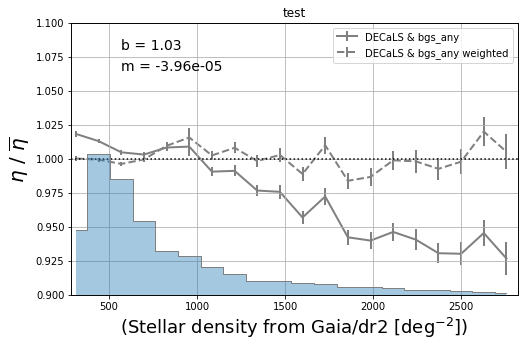

In [19]:
#
if reg[:8] == 'svfields': reg_ = reg+'_'+survey[0]
else: reg_ = reg

fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)
isdesi     = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0) #this should be rename as "mainreg"
nx         = 20

b0, m0, _, _ = plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['bgs_any'], regs=[reg_], syst='stardens', mainreg=isdesi, 
                      xlim=None, n=0, nx=nx, clip=True, denslims=False, ylab=True, weights=True, 
                          fig=fig, gs=gs, title='test', label=True)

In [20]:
#dic WEIGHTED

ws = 1./((m0)*hpdict['stardens'] + b0)

hpdict_ws = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=ran_ex['hppix'], hppix_cat=cat_ex['hppix'], 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ran_ex['desi'], catindesi=None, 
                                desifootprint=True, namesels={'bgs_any':20, 'bright':21, 'faint':22}, 
                                  galb=cat_ex['b'], log=True, survey='bgs', ws=ws)

In [21]:
from QA import pixhistregs

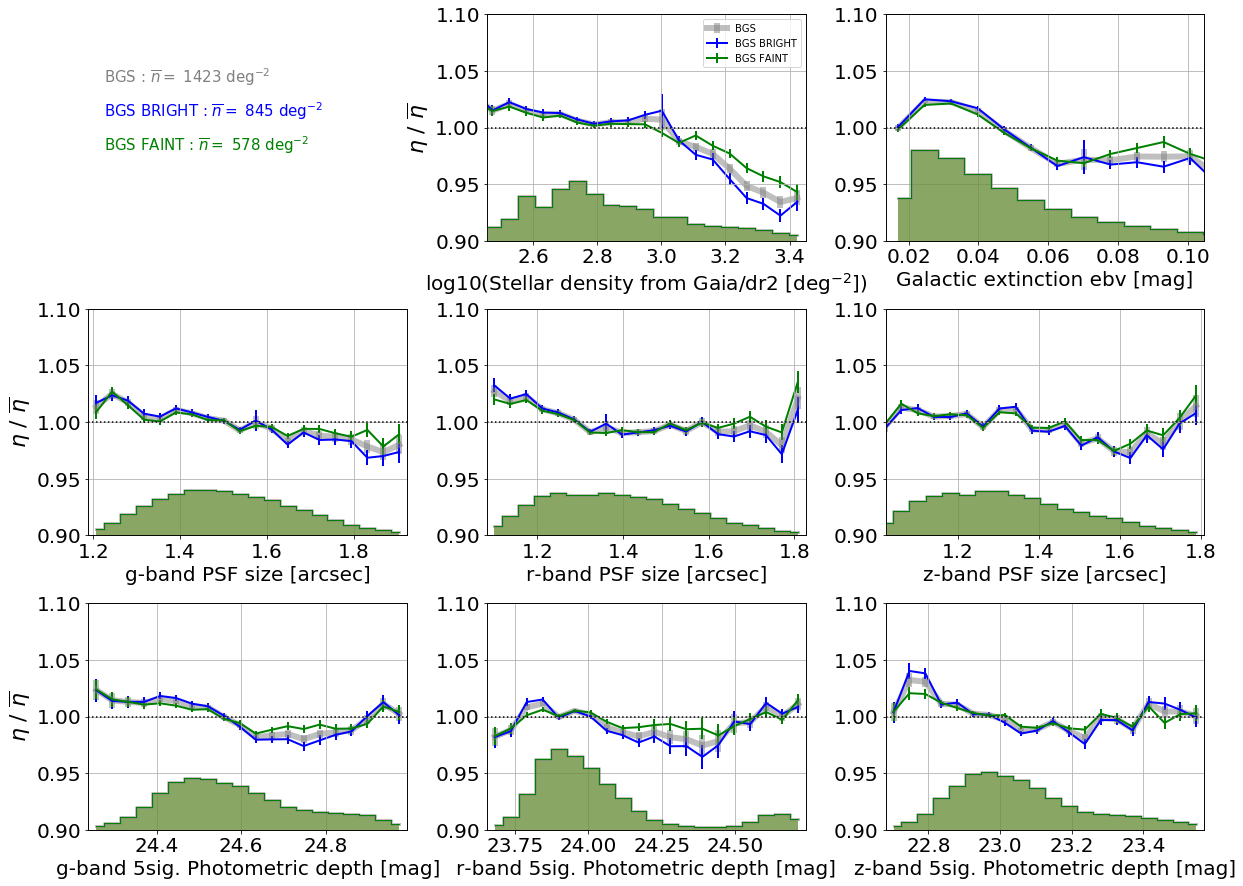

In [31]:
# dr8_south+north : density distributions + systematics

# settings
isdesi     = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0) #this should be rename as "mainreg"
systs      = ['log10_stardens','ebv','psfsize_g', 'psfsize_r', 'psfsize_z','galdepth_g', 'galdepth_r', 'galdepth_z']
nx         = 20
cols       = ['0.5','b','g','r']    
#regs = [reg]
namesels=['bgs_any', 'bright', 'faint']
namesel_dict = {'bgs_any':'BGS', 'bright':'BGS BRIGHT', 'faint':'BGS FAINT'}
#

# looping on subselections
#for key, title in zip([None, ws], ['UNWEIGHTED', 'WEIGHTED']):
#for key, title in zip([hpdict, hpdict_ws], ['UNWEIGHTED', 'WEIGHTED']):
for key, title in zip([hpdict], ['UNWEIGHTED']):
    
    # systematics
    fig    = plt.figure(figsize=(20,15))
    gs     = gridspec.GridSpec(3,3,hspace=0.30,wspace=0.25)
        
    for i in range(len(systs)+1):
        
        if i == 0:
            axinfo = fig.add_subplot(gs[i])
            # infos
            axinfo.axis('off')
            #axinfo.text(0.5,0.9,namesel,fontsize=20,fontweight='bold',ha='center',transform=axinfo.transAxes)
            tmpy = 0.7
            #for regi,col in zip(regs,cols):
            #if reg == 'south':reg_ = 'DECaLS+DES'
            #else: reg_ = reg
            for namesel,col in zip(namesels,cols):
                tmpstr = r'%s : $\overline{n}=$ %i deg$^{-2}$' %(namesel_dict[namesel], key['meandens_'+namesel+'_'+reg])
                #tmpstr = surveylab+' & '+namesel+' : '+r'$\overline{n}=$'+'%.0f'%key['meandens_'+namesel+'_'+reg]+r' deg$^{-2}$'
                axinfo.text(0.05,tmpy,tmpstr,color=col,fontsize=15,transform=axinfo.transAxes)
                tmpy  -= 0.15
        else:
            syst = systs[i-1]
            if (i%3==0) or (i==1): ylab=True
            else: ylab = False
            if i == 1: label = True
            else: label = False
            #if title == 'UNWEIGHTED': 
            #    weights = False
            #    onlyweights=False
            #else: 
            #    weights = True
            #    onlyweights=True
                
            ax = plot_sysdens(hpdicttmp=key, namesels=namesels, regs=[reg], syst=syst, mainreg=isdesi, xlim=None, n=i, nx=nx, clip=True, 
                         denslims=False, ylab=ylab, weights=False, fig=fig, gs=gs, label=label, title=None, 
                             ws=None, labels_size=(20,22), namesel_dict=namesel_dict)
            
            ax.tick_params(axis="x", labelsize=20)
            ax.tick_params(axis="y", labelsize=20)
            #ax.legend(fontsize=20)

    # save fig
    fig.savefig('%s/systematics_main_bgs_%s_%s.png' %(pathdir, survey, title), bbox_inches = 'tight', pad_inches = 0)
    print('')
    print('')
    
    #log10_stardens 2.4562973976135254 3.450467824935913 0.052324759332757244
    #ebv 0.013388573862612248 0.10473625697195531 0.004807772795228582

### Systematics with and withouth MS masking

In [28]:
bgs_MS = ((cat['BGSBITS'] & 2**(1)) != 0)
MS = ((cat['MASKBITS'] & 2**11)==0)
Ared = hpdict['bgsarea_'+reg]

namesels = {'bgs':bgs_any,
            'bgs & ~MS':((bgs_any) & (MS)), #BGS applying MS mask
            'bgs & ~MS & LG':((bgs_any) & (bgs_MS))} #BGS applying MS mask but without masking the large galaxies (except for LG around BS and GC)

for key, val in zip(namesels.keys(), namesels.values()):
    print('%s: \t %.2f (objects/sq.deg)' %(key, np.sum(val)/Ared))


bgs: 	 1393.85 (objects/sq.deg)
bgs & ~MS: 	 1374.42 (objects/sq.deg)
bgs & ~MS & LG: 	 1374.71 (objects/sq.deg)


In [29]:
hpdict_tmp = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=((rancuts['BS']) & (rancuts['MS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=True, namesels=namesels, galb=cat_ex['b'], log=True, survey='custom')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  68230483
bgsfracarea DONE...
regions DONE...
area_all = 4325 deg2
bgsarea_south = 0 deg2
bgsarea_decals = 0 deg2
bgsarea_des = 0 deg2
bgsarea_north = 4325 deg2
bgsarea_south_n = 0 deg2
bgsarea_south_s = 0 deg2
bgsarea_svfields = 193 deg2
bgsarea_svfields_n = 193 deg2
bgsarea_svfields_s = 0 deg2
bgsarea_svfields_fg = 92 deg2
bgsarea_svfields_fg_n = 92 deg2
bgsarea_svfields_fg_s = 0 deg2
bgsarea_svfields_ij = 53 deg2
bgsarea_svfields_ij_n = 53 deg2
bgsarea_svfields_ij_s = 0 deg2
areas DONE...
computing for  north / bgs
computing for  north / bgs & ~MS
computing for  north / bgs & ~MS & LG
target densities in north DONE...
computing for  south / bgs
computing for  south / bgs & ~MS
computing for  south / bgs & ~MS & LG
target densities in south DONE...
meandens_bgs_all = 1421 /deg2
meandens_bgs_south = nan /deg2
meandens_bgs_decals = nan /deg2
meandens_bgs_des = nan /deg2
meandens_bgs_north = 1421 /

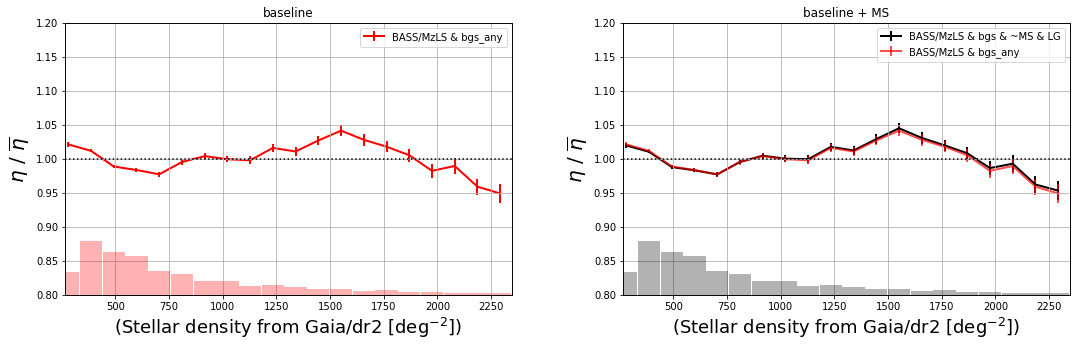

In [30]:
#
fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)
isdesi     = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0) #this should be rename as "mainreg"
nx         = 20
cols       = ['r','b','g','r']

x, y, yerr, lab = plot_sysdens(hpdicttmp=hpdict, namesels=['bgs_any'], regs=[reg_], syst='stardens', mainreg=isdesi, xlim=None, n=0, nx=nx, clip=True, 
                     denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='baseline', label=True, ws=None, cols=['r'], overbyreg=False, get_values=True)

ax = plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['bgs & ~MS & LG'], regs=[reg_], syst='stardens', mainreg=isdesi, xlim=None, n=1, nx=nx, clip=True, 
                     denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='baseline + MS', label=True, ws=None, cols=['k'], overbyreg=False)

ax.errorbar(x, y, yerr, color='r',ecolor='r',zorder=1,lw=2,alpha=0.7, label=lab)
ax.legend()


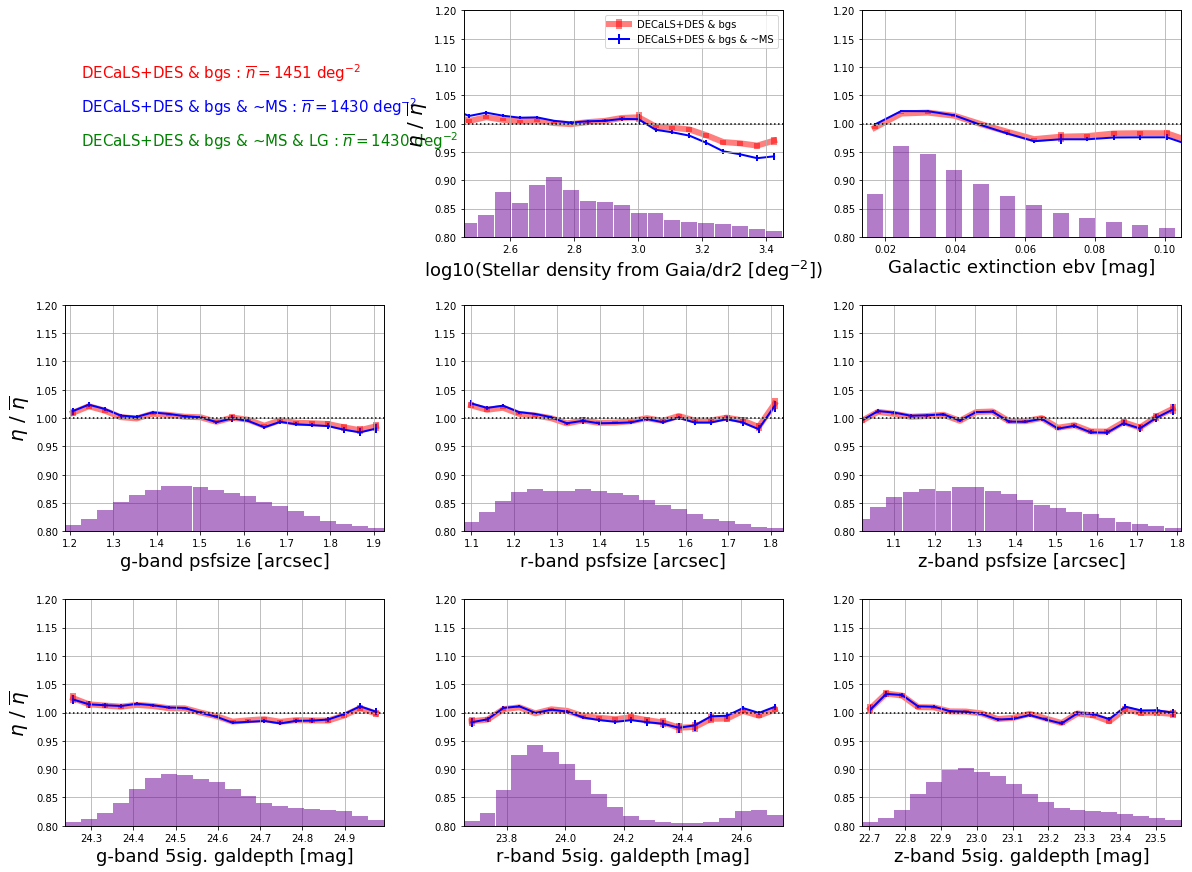

In [27]:
isdesi     = (hpdict_tmp['isdesi']) & (hpdict_tmp['bgsfracarea']>0) #this should be rename as "mainreg"
systs      = ['log10_stardens','ebv','psfsize_g', 'psfsize_r', 'psfsize_z','galdepth_g', 'galdepth_r', 'galdepth_z']
nx         = 20
cols       = ['r','b','g','r']    
    
# systematics
fig    = plt.figure(figsize=(20,15))
gs     = gridspec.GridSpec(3,3,hspace=0.30,wspace=0.25)

for i in range(len(systs)+1):

    if i == 0:
        axinfo = fig.add_subplot(gs[i])
        # infos
        axinfo.axis('off')
        #axinfo.text(0.5,0.9,namesel,fontsize=20,fontweight='bold',ha='center',transform=axinfo.transAxes)
        tmpy = 0.7
        #for regi,col in zip(regs,cols):
        #if reg == 'south':reg_ = 'DECaLS+DES'
        #else: reg_ = reg
        for namesel,col in zip(namesels,cols):
            tmpstr = surveylab+' & '+namesel+' : '+r'$\overline{n}=$'+'%.0f'%hpdict_tmp['meandens_'+namesel+'_'+reg]+r' deg$^{-2}$'
            axinfo.text(0.05,tmpy,tmpstr,color=col,fontsize=15,transform=axinfo.transAxes)
            tmpy  -= 0.15
    else:
        syst = systs[i-1]
        if (i%3==0) or (i==1): ylab=True
        else: ylab = False
        if i == 1: label = True
        else: label = False
        #if title == 'UNWEIGHTED': 
        #    weights = False
        #    onlyweights=False
        #else: 
        #    weights = True
        #    onlyweights=True

        plot_sysdens(hpdicttmp=hpdict_tmp, namesels=list(namesels.keys())[:-1], regs=[reg], syst=syst, mainreg=isdesi, xlim=None, n=i, nx=nx, clip=True, 
                     denslims=False, ylab=ylab, weights=False, fig=fig, gs=gs, label=label, title=None, 
                         ws=None, cols=cols, overbyreg=False)

# save fig
fig.savefig('%s/systematics_MS_comparison_%s_%s.png' %(pathdir, survey, 'unweighted'), bbox_inches = 'tight', pad_inches = 0)

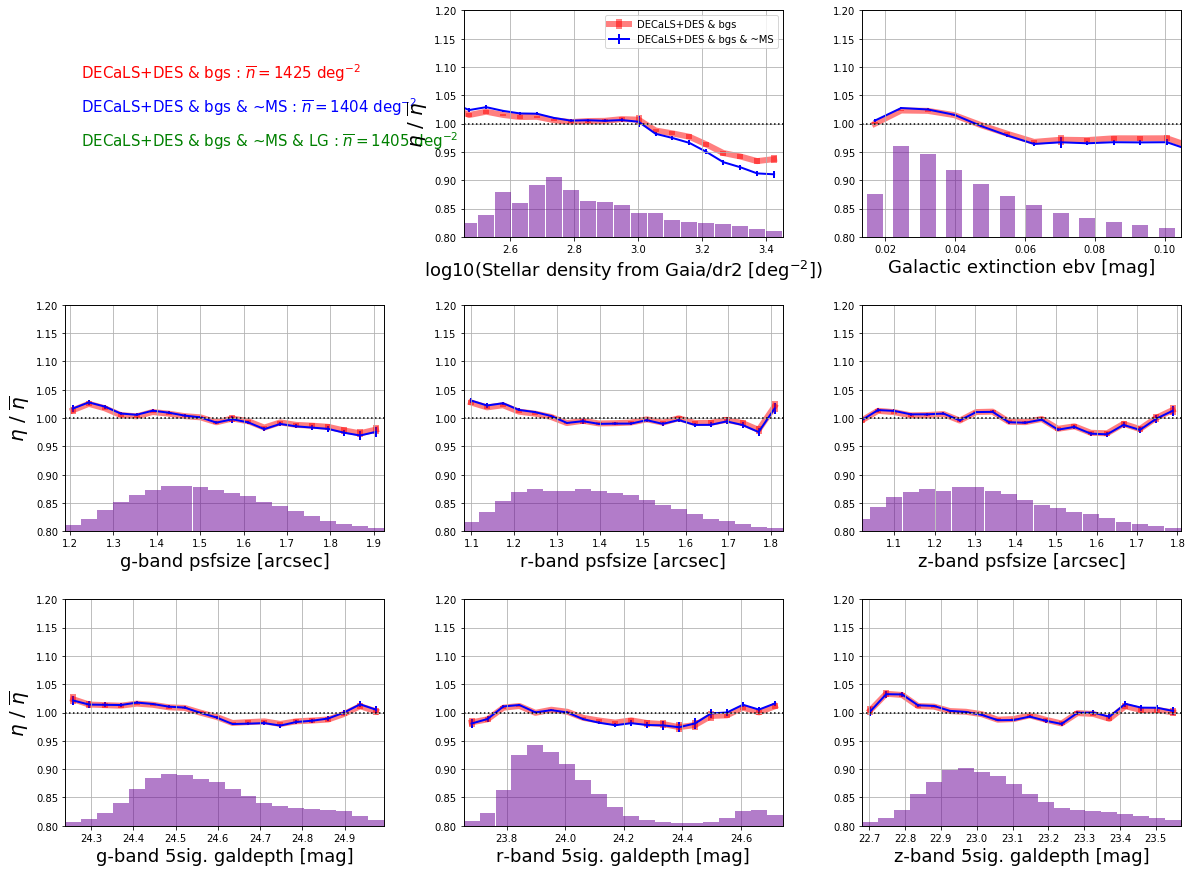

In [25]:
isdesi     = (hpdict_tmp['isdesi']) & (hpdict_tmp['bgsfracarea']>0) #this should be rename as "mainreg"
systs      = ['log10_stardens','ebv','psfsize_g', 'psfsize_r', 'psfsize_z','galdepth_g', 'galdepth_r', 'galdepth_z']
nx         = 20
cols       = ['r','b','g','r']    
    
# systematics
fig    = plt.figure(figsize=(20,15))
gs     = gridspec.GridSpec(3,3,hspace=0.30,wspace=0.25)

for i in range(len(systs)+1):

    if i == 0:
        axinfo = fig.add_subplot(gs[i])
        # infos
        axinfo.axis('off')
        #axinfo.text(0.5,0.9,namesel,fontsize=20,fontweight='bold',ha='center',transform=axinfo.transAxes)
        tmpy = 0.7
        #for regi,col in zip(regs,cols):
        #if reg == 'south':reg_ = 'DECaLS+DES'
        #else: reg_ = reg
        for namesel,col in zip(namesels,cols):
            tmpstr = surveylab+' & '+namesel+' : '+r'$\overline{n}=$'+'%.0f'%hpdict_tmp['meandens_'+namesel+'_'+reg]+r' deg$^{-2}$'
            axinfo.text(0.05,tmpy,tmpstr,color=col,fontsize=15,transform=axinfo.transAxes)
            tmpy  -= 0.15
    else:
        syst = systs[i-1]
        if (i%3==0) or (i==1): ylab=True
        else: ylab = False
        if i == 1: label = True
        else: label = False
        #if title == 'UNWEIGHTED': 
        #    weights = False
        #    onlyweights=False
        #else: 
        #    weights = True
        #    onlyweights=True

        plot_sysdens(hpdicttmp=hpdict_tmp, namesels=list(namesels.keys())[:-1], regs=[reg], syst=syst, mainreg=isdesi, xlim=None, n=i, nx=nx, clip=True, 
                     denslims=False, ylab=ylab, weights=False, fig=fig, gs=gs, label=label, title=None, 
                         ws=None, cols=cols)

# save fig
fig.savefig('%s/systematics_MS_comparison_%s_%s.png' %(pathdir, survey, 'unweighted'), bbox_inches = 'tight', pad_inches = 0)

### Systematics separated by best model fitted

In [19]:
namesels = {}
for i in ['COMP', 'DEV ', 'EXP ', 'PSF ', 'REX ']:
    namesels[i] = (cat['TYPE'] == i) & (bgs_any)

In [20]:
hpdict_tmp = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=True, namesels=namesels, galb=cat_ex['b'], log=True, survey='custom')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  145754705
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / COMP
computing for  north / DEV 
computing for  north / EXP 
computing for  north / PSF 
computing for  north / REX 
target densities in north DONE...
computing for  south / COMP
computing for  south / DEV 
computing for  south / EXP 
computing for  south / PSF 
computing for  south / REX 
target densities in south DONE...
meandens_COMP_all = 31 /deg2
meandens_COMP_des = 50 /deg2
meandens_COMP_decals = 28 /deg2
meandens_COMP_north = nan /deg2
meandens_COMP_south = 31 /deg2
meandens_COMP_svfields = 34 /deg2
meandens_COMP_svfields_n = nan /deg2
meandens_COMP_svfields_s = 34 /deg2
meandens_DEV _all = 630 /deg2
meandens_DEV _des = 650 /deg2
meandens_DEV _decals = 627 /deg2
meandens_DEV _north = nan /deg2
meandens_DEV _south = 630 /deg2
meandens_DEV _svfields = 655 /deg2
meandens_DEV _svfields_n = nan /deg2
meandens_DEV

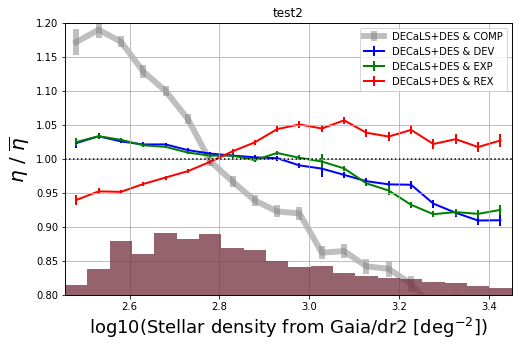

In [27]:
fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)
isdesi     = (hpdict_tmp['isdesi']) & (hpdict_tmp['bgsfracarea']>0)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['COMP', 'DEV ', 'EXP ', 'REX '], regs=[reg], 
                 syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=20, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test2', label=True)

### Systematics separated by rmag bins

In [30]:
namesels = {}
mags = np.linspace(16, 20, 9)
for i in range(len(mags[:-1])):
    namesels['%s_%s' %(str(mags[i]), str(mags[i+1]))] = (cat['RMAG'] > mags[i]) & (cat['RMAG'] < mags[i+1]) & (bgs_any)

In [31]:
namesels.keys()

dict_keys(['16.0_16.5', '16.5_17.0', '17.0_17.5', '17.5_18.0', '18.0_18.5', '18.5_19.0', '19.0_19.5', '19.5_20.0'])

In [32]:
hpdict_tmp = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=True, namesels=namesels, galb=cat_ex['b'], log=True, survey='custom')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  145754705
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / 16.0_16.5
computing for  north / 16.5_17.0
computing for  north / 17.0_17.5
computing for  north / 17.5_18.0
computing for  north / 18.0_18.5
computing for  north / 18.5_19.0
computing for  north / 19.0_19.5
computing for  north / 19.5_20.0
target densities in north DONE...
computing for  south / 16.0_16.5
computing for  south / 16.5_17.0
computing for  south / 17.0_17.5
computing for  south / 17.5_18.0
computing for  south / 18.0_18.5
computing for  south / 18.5_19.0
computing for  south / 19.0_19.5
computing for  south / 19.5_20.0
target densities in south DONE...
meandens_16.0_16.5_all = 12 /deg2
meandens_16.0_16.5_des = 12 /deg2
meandens_16.0_16.5_decals = 12 /deg2
meandens_16.0_16.5_north = nan /deg2
meandens_16.0_16.5_south = 12 /deg2
meandens_16.0_16.5_svfields = 11 /deg2
meandens_16.0_16.5_svfields_n = nan 

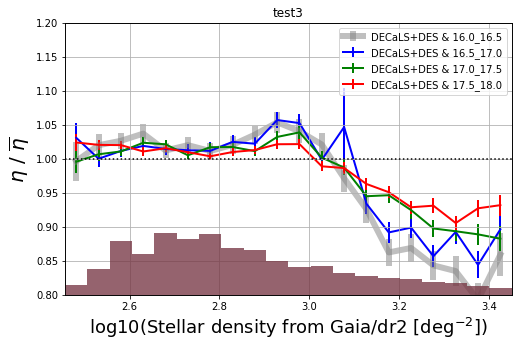

In [33]:
fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)
isdesi     = (hpdict_tmp['isdesi']) & (hpdict_tmp['bgsfracarea']>0)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['16.0_16.5', '16.5_17.0', '17.0_17.5', '17.5_18.0'], regs=[reg], 
                 syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=20, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test3', label=True)

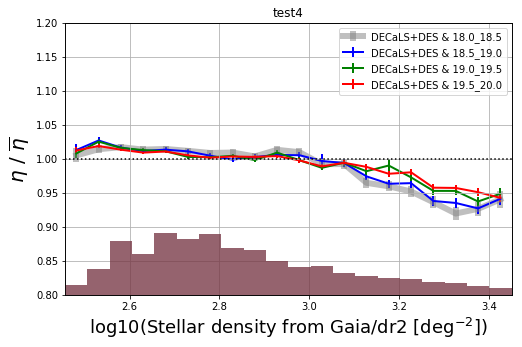

In [34]:
fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)
isdesi     = (hpdict_tmp['isdesi']) & (hpdict_tmp['bgsfracarea']>0)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['18.0_18.5', '18.5_19.0', '19.0_19.5', '19.5_20.0'], regs=[reg], 
                 syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=20, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test4', label=True)

# Skymap footprint
Below code only needs the randoms.

area_all: 	 20332.475(whole) 	 14265.679(desifootprint)
bgsarea_south: 	 15173.940(whole) 	 9716.980(desifootprint)
bgsarea_north: 	 5158.535(whole) 	 4548.699(desifootprint)
bgsarea_des: 	 5060.633(whole) 	 1113.520(desifootprint)
NGC DECaLS in DESI footprint: 	 5322.602
SGC DECaLS in DESI footprint: 	 4394.378


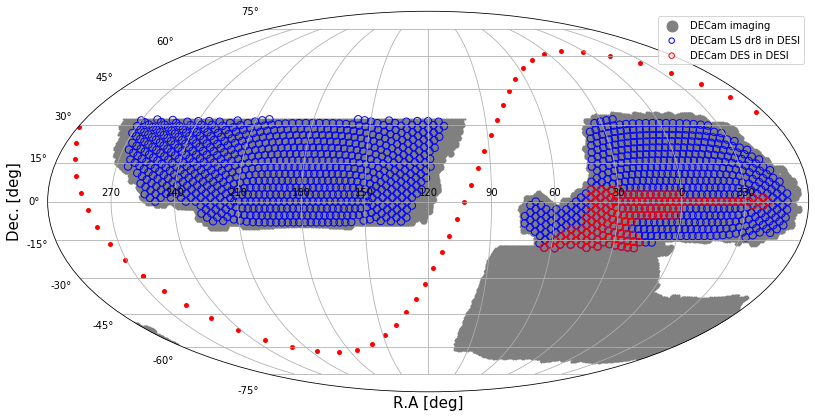

In [5]:
#
from QA import set_mwd, get_radec_mw
from io_ import get_isdes

# dict without geometrical mask and in WHOLE SWEEPS footprint
hpdict0 = get_dict(cat=None, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=None, 
                      maskrand=None, maskcat=None, Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                            desifootprint=False, namesels=None, target_outputs=False, log=False)
# dict without geometrical mask and in DESI footprint
hpdict1 = get_dict(cat=None, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=None, 
                      maskrand=None, maskcat=None, Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                            desifootprint=True, namesels=None, target_outputs=False, log=False)

#
for i in ['area_all', 'bgsarea_south', 'bgsarea_north', 'bgsarea_des']:
    print('%s: \t %.3f(whole) \t %.3f(desifootprint)' %(i, hpdict0[i], hpdict1[i]))
    
if survey == 'south':
    # DECaLS area in the NGC/SGC within DESI footprint
    area_decals_ngc = hpdict1['bgsfracarea'][(hpdict1['issouth']) & (hpdict1['galb'] > 0)].sum() * pixarea
    area_decals_sgc = hpdict1['bgsfracarea'][(hpdict1['issouth']) & (hpdict1['galb'] < 0)].sum() * pixarea
    print('NGC DECaLS in DESI footprint: \t %.3f' %(area_decals_ngc))
    print('SGC DECaLS in DESI footprint: \t %.3f' %(area_decals_sgc))
    
if survey == 'north':
    # DECaLS area in the NGC/SGC within DESI footprint
    area_bass_ngc = hpdict1['bgsfracarea'][(hpdict1['isnorth']) & (hpdict1['galb'] > 0)].sum() * pixarea
    print('NGC BASS/MzLS in DESI footprint: \t %.3f' %(area_bass_ngc))

desitiles = fitsio.read('/global/homes/q/qmxp55/desi-tiles-viewer.fits')
org          = 120  # centre ra for mollweide plots
projection   = 'mollweide'

# plotting bgsfracarea
fig = plt.figure(figsize=(14, 7))
gs = gridspec.GridSpec(1,1,wspace=0.15,hspace=0)

ax = plt.subplot(gs[0],projection=projection)
_ = set_mwd(ax,org=org)
ramw,decmw = get_radec_mw(hpdict0['ra'],hpdict0['dec'],org)
tmp        = (hpdict0['bgsfracarea']>0) & (hpdict0['is'+survey])
if survey == 'south':
    SC         = ax.scatter(ramw[tmp],decmw[tmp],s=0.4, color='gray', label=r'DECam imaging')
if survey == 'north':
    SC         = ax.scatter(ramw[tmp],decmw[tmp],s=0.4, color='gray', label=r'BASS/MzLS imaging')

ramw,decmw = get_radec_mw(desitiles['ra'],desitiles['dec'],org)
if survey == 'south':
    tmp = (desitiles['in_desi'] ==  1) & (desitiles['dec'] < dec_resol_ns)
    SC         = ax.scatter(ramw[tmp],decmw[tmp], marker='.', s = 220, facecolors='none', edgecolors='blue', label=r'DECam LS dr8 in DESI')
if survey == 'north':
    tmp = (desitiles['in_desi'] ==  1) & (desitiles['dec'] > dec_resol_ns)
    SC         = ax.scatter(ramw[tmp],decmw[tmp], marker='.', s = 220, facecolors='none', edgecolors='blue', label=r'BASS/MzLS dr8 in DESI')


if survey == 'south':
    desitilesindes = get_isdes(desitiles['ra'],desitiles['dec'])
    tmp = (desitiles['in_desi'] ==  1) & (desitiles['dec'] < dec_resol_ns) & (desitilesindes)
    SC         = ax.scatter(ramw[tmp],decmw[tmp], marker='.', s = 220, facecolors='none', edgecolors='red', label=r'DECam DES in DESI')

gc = SkyCoord(l=np.linspace(0, 360, 50)*units.degree, b=np.full(50, 0)*units.degree, frame='galactic')
ramw,decmw = get_radec_mw(gc.icrs.ra.value, gc.icrs.dec.value,org)
SC         = ax.scatter(ramw, decmw, color='r', marker='.', lw=2)

lgnd = ax.legend()
[handle.set_sizes([120.0]) for handle in lgnd.legendHandles]

fig.savefig('%s/skyplot_%s.png' %(pathdir, survey), bbox_inches = 'tight', pad_inches = 0)


## get area by number of passes + skymap of regions

In [7]:
# get the area covered by the number of passes from 1 to 3 and per band and for the joint bands.
Apasses = {}
for i in [0, 1, 2]:
    for j in ['G', 'R', 'Z', 'all']:
        
        if j == 'all': mask = (ran['NOBS_G'] > i) & (ran['NOBS_R'] > i) & (ran['NOBS_Z'] > i)
        else: mask = (ran['NOBS_'+j] > i)
            
        hpdicttest = get_dict(pixmapfile=dr8pix, hppix_ran=hppix_ran, maskrand=mask, Nranfiles=Nranfiles, 
                              ranindesi=ranindesi, desifootprint=True, target_outputs=False)
        
        for k in ['south', 'north', 'decals', 'des']:
            Apasses[j+str(i+1)+'_'+k] = hpdicttest['bgsarea_'+k]
        Apasses[j+str(i+1)+'_'+'all'] = hpdicttest['area_all']
            
        print('%s >= %i: \t south: %2.3g, north: %2.3g, decals: %2.3g, des: %2.3g, all: %2.3g' 
              %(j, i+1, hpdicttest['bgsarea_south'], hpdicttest['bgsarea_north'], hpdicttest['bgsarea_decals'], 
                    hpdicttest['bgsarea_des'], hpdicttest['area_all']))

G >= 1: 	 south: 9.69e+03, north: 4.54e+03, decals: 8.57e+03, des: 1.11e+03, all: 1.42e+04
R >= 1: 	 south: 9.69e+03, north: 4.54e+03, decals: 8.57e+03, des: 1.11e+03, all: 1.42e+04
Z >= 1: 	 south: 9.69e+03, north: 4.54e+03, decals: 8.57e+03, des: 1.11e+03, all: 1.42e+04
all >= 1: 	 south: 9.67e+03, north: 4.52e+03, decals: 8.56e+03, des: 1.11e+03, all: 1.42e+04
G >= 2: 	 south: 9.45e+03, north: 4.49e+03, decals: 8.34e+03, des: 1.11e+03, all: 1.39e+04
R >= 2: 	 south: 9.42e+03, north: 4.49e+03, decals: 8.31e+03, des: 1.11e+03, all: 1.39e+04
Z >= 2: 	 south: 9.49e+03, north: 4.49e+03, decals: 8.37e+03, des: 1.11e+03, all: 1.4e+04
all >= 2: 	 south: 9.26e+03, north: 4.41e+03, decals: 8.15e+03, des: 1.11e+03, all: 1.37e+04
G >= 3: 	 south: 7.77e+03, north: 3.93e+03, decals: 6.66e+03, des: 1.11e+03, all: 1.17e+04
R >= 3: 	 south: 7.57e+03, north: 3.9e+03, decals: 6.46e+03, des: 1.11e+03, all: 1.15e+04
Z >= 3: 	 south: 8.04e+03, north: 3.89e+03, decals: 6.93e+03, des: 1.11e+03, all: 1.19e+

In [8]:
#
print('BAND \t >= 1 \t\t >= 2 \t\t >= 3')
print('------------------------------------------')
for band in ['G', 'R', 'Z', 'all']:
    lab1 = band+'1'+'_south'
    lab2 = band+'2'+'_south'
    lab3 = band+'3'+'_south'
    
    print('%s: \t %.0f \t %.0f \t %.0f' %(band, Apasses[lab1], Apasses[lab2], Apasses[lab3]))


BAND 	 >= 1 		 >= 2 		 >= 3
------------------------------------------
G: 	 9687 	 9454 	 7769
R: 	 9686 	 9422 	 7569
Z: 	 9686 	 9487 	 8036
all: 	 9669 	 9257 	 6870


# DEV ZONE

In [68]:
#bgslist = ['BS', 'LG', 'GC', 'nobs', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF', 'QC_IVAR']
bgsbut20 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['QC_FM','QC_FI','QC_FF','QC_IVAR', 'FMC2', 'CC', 'nobs', 'BS', 'LG', 'GC'], bgsmask=bgsmask(), rlimit=20)
bgsbut201 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['QC_FM','QC_FI','QC_FF','QC_IVAR', 'FMC2', 'CC', 'nobs', 'BS', 'LG', 'GC'], bgsmask=bgsmask(), rlimit=20.1)
bgsbut205 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['QC_FM','QC_FI','QC_FF','QC_IVAR', 'FMC2', 'CC', 'nobs', 'BS', 'LG', 'GC'], bgsmask=bgsmask(), rlimit=20.5)
bgsbut207 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['QC_FM','QC_FI','QC_FF','QC_IVAR', 'FMC2', 'CC', 'nobs', 'BS', 'LG', 'GC'], bgsmask=bgsmask(), rlimit=20.7)
#bgsbutCC = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['CC'], bgsmask=bgsmask())
#bgsbutFMC2 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['FMC2'], bgsmask=bgsmask())
#bgsbutBSLG = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['BS', 'LG'], bgsmask=bgsmask())

In [43]:
bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)

In [69]:
namesels = {}
#namesels['bgs_any'] = bgs_any
namesels['bgsbut20'] = bgsbut20
namesels['bgsbut201'] = bgsbut201
namesels['bgsbut205'] = bgsbut205
namesels['bgsbut207'] = bgsbut207

In [70]:
#dic with default BGS selection and in DESI footprint
#maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs']))
hpdict_tmp = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=None,
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=True, namesels=namesels, galb=galb, log=True, survey='custom')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  145754705
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / bgsbut20
computing for  north / bgsbut201
computing for  north / bgsbut205
computing for  north / bgsbut207
target densities in north DONE...
computing for  south / bgsbut20
computing for  south / bgsbut201
computing for  south / bgsbut205
computing for  south / bgsbut207
target densities in south DONE...
meandens_bgsbut20_all = 1452 /deg2
meandens_bgsbut20_des = 1442 /deg2
meandens_bgsbut20_decals = 1453 /deg2
meandens_bgsbut20_north = nan /deg2
meandens_bgsbut20_south = 1452 /deg2
meandens_bgsbut20_svfields = 1466 /deg2
meandens_bgsbut20_svfields_n = nan /deg2
meandens_bgsbut20_svfields_s = 1466 /deg2
meandens_bgsbut201_all = 1608 /deg2
meandens_bgsbut201_des = 1596 /deg2
meandens_bgsbut201_decals = 1610 /deg2
meandens_bgsbut201_north = nan /deg2
meandens_bgsbut201_south = 1608 /deg2
meandens_bgsbut201_svfields =

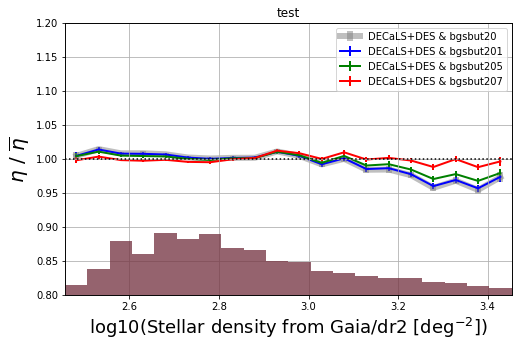

In [71]:
fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)
isdesi     = (hpdict_tmp['isdesi']) & (hpdict_tmp['bgsfracarea']>0)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['bgsbut20', 'bgsbut201', 'bgsbut205', 'bgsbut207'], regs=[reg], 
                 syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=20, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test', label=True)

#plot_sysdens(hpdicttmp=hpdict_tmp, namesels=[ 'bgs_19.0_19.5', 'bgs_19.5_20.0'], regs=[reg], syst='log10_stardens', mainreg=isdesi, xlim=None, n=1, nx=nx, clip=True, 
#                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test', label=True)


In [73]:
#bgslist = ['BS', 'LG', 'GC', 'nobs', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF', 'QC_IVAR']
bgsbut20 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=None, bgsmask=bgsmask(), rlimit=20)
bgsbut201 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=None, bgsmask=bgsmask(), rlimit=20.1)
bgsbut205 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=None, bgsmask=bgsmask(), rlimit=20.5)
bgsbut207 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=None, bgsmask=bgsmask(), rlimit=20.7)

In [74]:
namesels = {}
namesels['bgsbut20'] = bgsbut20
namesels['bgsbut201'] = bgsbut201
namesels['bgsbut205'] = bgsbut205
namesels['bgsbut207'] = bgsbut207

In [75]:
#dic with default BGS selection and in DESI footprint
#maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs']))
hpdict_tmp = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=True, namesels=namesels, galb=galb, log=True, survey='custom')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  145754705
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / bgsbut20
computing for  north / bgsbut201
computing for  north / bgsbut205
computing for  north / bgsbut207
target densities in north DONE...
computing for  south / bgsbut20
computing for  south / bgsbut201
computing for  south / bgsbut205
computing for  south / bgsbut207
target densities in south DONE...
meandens_bgsbut20_all = 1426 /deg2
meandens_bgsbut20_des = 1430 /deg2
meandens_bgsbut20_decals = 1425 /deg2
meandens_bgsbut20_north = nan /deg2
meandens_bgsbut20_south = 1426 /deg2
meandens_bgsbut20_svfields = 1437 /deg2
meandens_bgsbut20_svfields_n = nan /deg2
meandens_bgsbut20_svfields_s = 1437 /deg2
meandens_bgsbut201_all = 1578 /deg2
meandens_bgsbut201_des = 1583 /deg2
meandens_bgsbut201_decals = 1578 /deg2
meandens_bgsbut201_north = nan /deg2
meandens_bgsbut201_south = 1578 /deg2
meandens_bgsbut201_svfields =

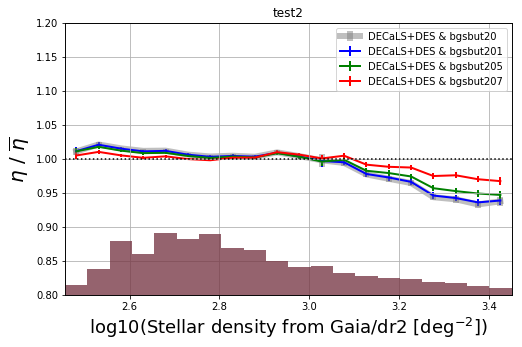

In [76]:
fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)
isdesi     = (hpdict_tmp['isdesi']) & (hpdict_tmp['bgsfracarea']>0)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['bgsbut20', 'bgsbut201', 'bgsbut205', 'bgsbut207'], regs=[reg], 
                 syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=20, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test2', label=True)

#plot_sysdens(hpdicttmp=hpdict_tmp, namesels=[ 'bgs_19.0_19.5', 'bgs_19.5_20.0'], regs=[reg], syst='log10_stardens', mainreg=isdesi, xlim=None, n=1, nx=nx, clip=True, 
#                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test', label=True)


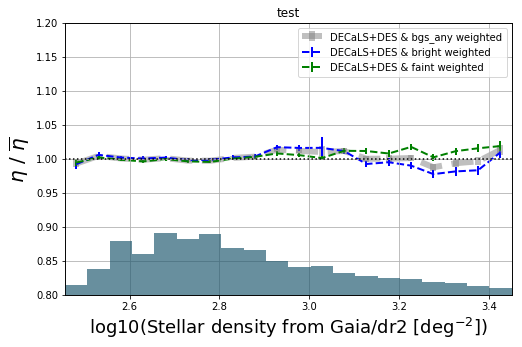

In [80]:
#
ws = 1./((-3.96*10**(-5))*hpdict['stardens'] + 1.03)

fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)

plot_sysdens(hpdicttmp=hpdict, namesels=['bgs_any', 'bright', 'faint'], regs=[reg], syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=nx, clip=True, 
                         denslims=False, ylab=True, weights=True, fig=fig, gs=gs, title='test', label=True, ws=ws, onlyweights=True)

In [88]:
hpdict['meandens_bgs_any_south']

1425.646415390457

In [89]:
hpdict_tmp['meandens_bgs_any_south']

1432.660001909052

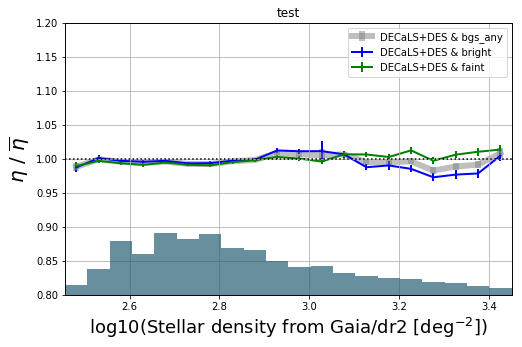

In [90]:
#
#ws = 1./((-3.96*10**(-5))*hpdict['stardens'] + 1.03)

fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['bgs_any', 'bright', 'faint'], regs=[reg], syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=nx, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test', label=True, ws=None, onlyweights=False)

In [53]:
bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)
namesels = {}
mags = [15, 18, 18.5, 19.0, 19.5, 20.0]
for num,i in enumerate(mags[:-1]):
    namesels['bgs_%s_%s' %(str(mags[num]), str(mags[num+1]))] = (bgs_any) & (cat['RMAG'] > mags[num]) & (cat['RMAG'] < mags[num+1])
    

In [55]:
#dic with default BGS selection and in DESI footprint
hpdict_tmp = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=True, namesels=namesels, galb=galb, log=True, survey='custom')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  145754705
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / bgs_15_18
computing for  north / bgs_18_18.5
computing for  north / bgs_18.5_18.5
computing for  north / bgs_18.5_19.0
computing for  north / bgs_19.0_19.5
computing for  north / bgs_19.5_20.0
target densities in north DONE...
computing for  south / bgs_15_18
computing for  south / bgs_18_18.5
computing for  south / bgs_18.5_18.5
computing for  south / bgs_18.5_19.0
computing for  south / bgs_19.0_19.5
computing for  south / bgs_19.5_20.0
target densities in south DONE...
meandens_bgs_15_18_all = 154 /deg2
meandens_bgs_15_18_des = 153 /deg2
meandens_bgs_15_18_decals = 154 /deg2
meandens_bgs_15_18_north = nan /deg2
meandens_bgs_15_18_south = 154 /deg2
meandens_bgs_15_18_svfields = 151 /deg2
meandens_bgs_15_18_svfields_n = nan /deg2
meandens_bgs_15_18_svfields_s = 151 /deg2
meandens_bgs_18_18.5_all = 124 /deg2
meande

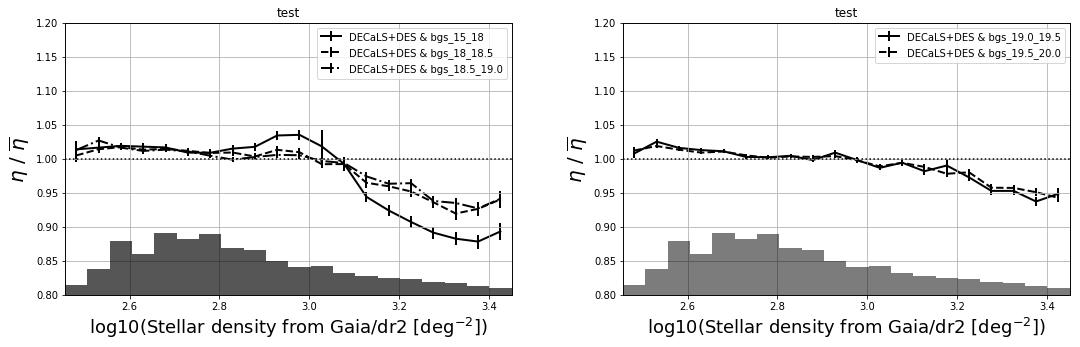

In [60]:
fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['bgs_15_18', 'bgs_18_18.5', 'bgs_18.5_19.0'], regs=[reg], syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=nx, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test', label=True)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=[ 'bgs_19.0_19.5', 'bgs_19.5_20.0'], regs=[reg], syst='log10_stardens', mainreg=isdesi, xlim=None, n=1, nx=nx, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test', label=True)


In [ ]:
bgs_bright = ((cat['BGSBITS'] & 2**(21)) != 0)
bgs_faint = ((cat['BGSBITS'] & 2**(22)) != 0)
bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)